In [183]:
GBM <- function(data, y0, q0, yf, qf, n_shock, shock_par, shock_type, company, quantity)   
    #data: time-series data
    #y0, q0: begin year and quartile
    #yf, qf: end year and quartile
    #n_shock: number of shocks
    #shock_par : vector with a, b, c parameter for each shock
    #shock_type : 'exp', 'rett', 'mixed'

{
    #tsdisplay(data)
    #tsdisplay(diff(diff(data, 4)))
    BM <- BASS.standard(data, display=F)
    c <- coef(BM)
    GBM <- BASS.generalized(data,  shock = shock_type, nshock = n_shock, prelimestimates = c(c[1], c[2], c[3], shock_par),display=F)
    fit_GBM <- ts(data = fitted(GBM), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    fit_BM <- ts(data = fitted(BM), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    
    filename = paste('plots/', company, quantity, '_Gbass.png', sep = "")
    #png(filename, res=100)
    plot(data, main=paste(company, quantity, 'in billion U.S. dollars', sep = " "), xlab='year', ylab='[billion $]' )
    lines(fit_BM, col ='red', lty=2, lwd=2)
    lines(fit_GBM, col ='blue', lty=3, lwd=2)
    legend('topleft', legend=c("data", "Bass Model", "Generalized Bass Model"),
       col=c('black', 'red', 'blue'), lty=1:3, cex=0.8)
    
    #dev.off()

    res_GBM <- residuals(GBM)
    ts_res_GBM <- ts(data = res_GBM, start = c(y0, q0), end = c(yf, qf), frequency = 4)


    filename = paste('plots/residuals_', company, quantity, '_Gbass.png', sep = "")
    png(filename, res=100)
    tsdisplay(ts_res_GBM, main = paste(company, quantity, 'residuals on generalized Bass model', sep=' '))
    dev.off()
    return(GBM)

}

BM <- function(data, y0, q0, yf, qf, company, quantity)   
    #data: time-series data
    #y0, q0: begin year and quartile
    #yf, qf: end year and quartile
    #n_shock: number of shocks
    #shock_par : vector with a, b, c parameter for each shock
    #shock_type : 'exp', 'rett', 'mixed'

{
    #tsdisplay(data)
    #tsdisplay(diff(diff(data, 4)))
    BM <- BASS.standard(data, display=F)
    coef(BM)
    fit_BM <- ts(data = fitted(BM), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    
    plot(data)
    lines(fit_BM, col =2)

    
    res_BM <- residuals(BM)
    ts_res_BM <- ts(data = res_BM, start = c(y0, q0), end = c(yf, qf), frequency = 4)


    filename = paste('plots/residuals_', company, quantity, '_Bass.png', sep = "")
    png(filename, res=100)
    tsdisplay(ts_res_BM, main = paste(company, quantity, 'residuals on Bass model', sep=' '))
    dev.off()
    #tsdisplay(res_BM)
    return(BM)

}

R_nested_models <- function(m1, m2) {
    R1 <- m1$RsquaredAdj
    R2 <- m2$RsquaredAdj
    R <- ( R2 - R1 ) / ( 1 - R1 )
    return (R)
}



SARIMA_GBM <- function (data, y0, q0, yf, qf, GBM_model,  arima_order, seasonal_order) {
    
    fit_GBM <- ts(data = fitted(GBM_model), start = c(y0, q0), end = c(yf, qf), frequency = 4)

#    arima_GBM <- SARMAX.refinement(GBM_model,arima_order = arima_order,seasonal_order = seasonal_order, period=4,display = F) 
    
    arima_GBM <- Arima(data, order = arima_order,seasonal = list(order=seasonal_order,period=4),
                       xreg = fitted(GBM_model))
    #fit_arima_GBM <-fitted(arima_GBM)
    #plot(data, type="l")
    #lines(fit_GBM, col=2)
    #lines(fit_arima_GBM, col=4)

    #res_arima_GBM <- residuals(arima_GBM)
    #tsdisplay(res_arima_GBM)
    return(arima_GBM)
    
}


plotting <- function(data, BM, GBM, SARIMA, y0, q0, yf, qf, company, quantity, best_model) {
    
    fit_GBM <- ts(data = fitted(GBM), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    fit_BM <- ts(data = fitted(BM), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    fit_SARIMA <-ts(data=fitted(SARIMA), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    name_sarima <- paste(best_model, '+ SARIMA', sep=' ')




    
    filename = paste('plots/', company,'_', quantity, '_complete.png', sep = "")
    png(filename, res=100)
    plot(data,  main=paste(company, quantity, 'in billion U.S. dollars', sep = " "), xlab='year', ylab='[billion $]' )
    lines(fit_BM, col ='red', lty=2, lwd=2)
    lines(fit_GBM, col ='blue', lty=3, lwd=2)
    lines(fit_SARIMA, col='green', lty=4, lwd=1)
    


    legend('bottomright', legend=c("data", "Bass Model", "Generalized Bass Model", name_sarima),
       col=c('black', 'red', 'blue', 'green'), lty=1:4, cex=0.65)
    
    dev.off()
    

    res_SARIMA<- residuals(SARIMA)
    ts_res_SARIMA<- ts(data = res_SARIMA, start = c(y0, q0), end = c(yf, qf), frequency = 4)


    filename = paste('plots/residuals_SARIMA_', company, quantity, '.png', sep = "")
    png(filename, res=100)
    tsdisplay(ts_res_SARIMA, main = paste(company, quantity, '\n residuals on', name_sarima, sep=' '))
    dev.off()
    
}






forecasting <- function(SARIMA, GBM, y0, q0, yf, qf,  newx, company, quantity) {
    
    
fit_arima_GBM <-fitted(SARIMA)
fit_GBM <- ts(data = fitted(GBM), start = c(y0, q0), end = c(yf, qf), frequency = 4)
    
    
    
filename = paste('plots/forecast_', company, '_', quantity, '.png', sep = "")
png(filename, res=100)   
plot(forecast(SARIMA, xreg = predict(GBM, newx = newx)), 
     main=paste(company, quantity, 'Bass+SARIMA forecasting', sep=' '))

lines(fit_GBM, col='red', lty=2)
lines(fit_arima_GBM, col='blue', lty=3)
legend('topleft', legend=c("forecast", "Bass fitting", "Bass+SARIMA fitting"),
       col=c('black', 'red', 'blue'), lty=1:3, cex=0.8)
    
dev.off()


}


plot_residuals  <- function(SARIMA,  y0, q0, yf, qf, company, quantity)   {
    
    filename = paste('plots/residuals_SARIMA_GBM_', company, '_', quantity, '.png', sep = "")
    png(filename, res=100)   
    res <- residuals(SARIMA)
    ts_res <- ts(data = res, start = c(y0, q0), end = c(yf, qf), frequency = 4)


    tsdisplay(ts_res, main = paste(company, quantity, 'residuals on Bass+SARIMA', sep=' '))
    dev.off()
    
}

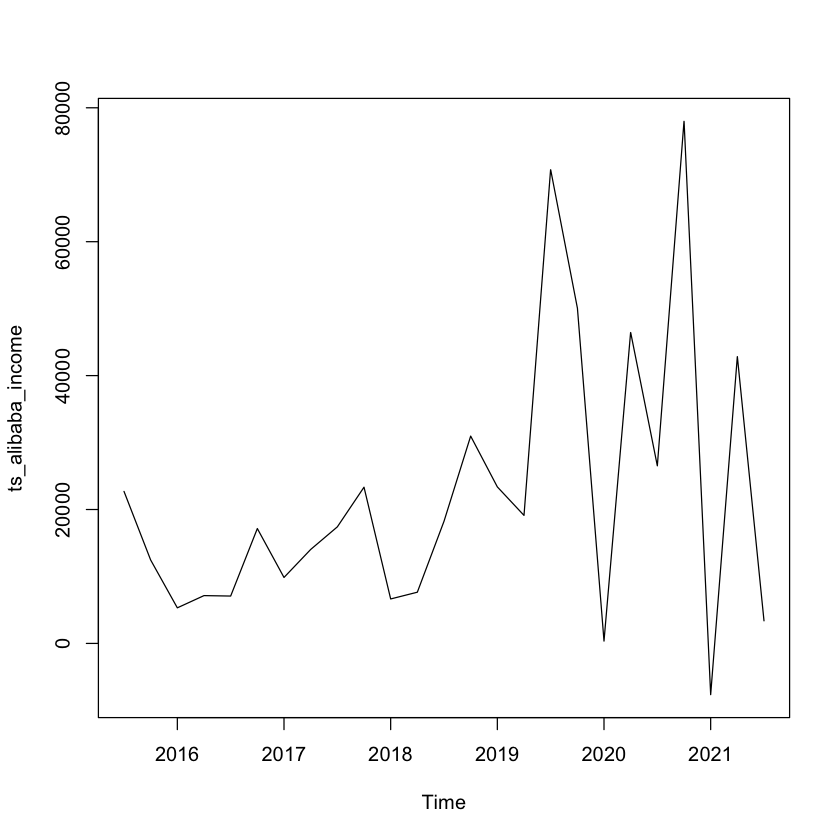

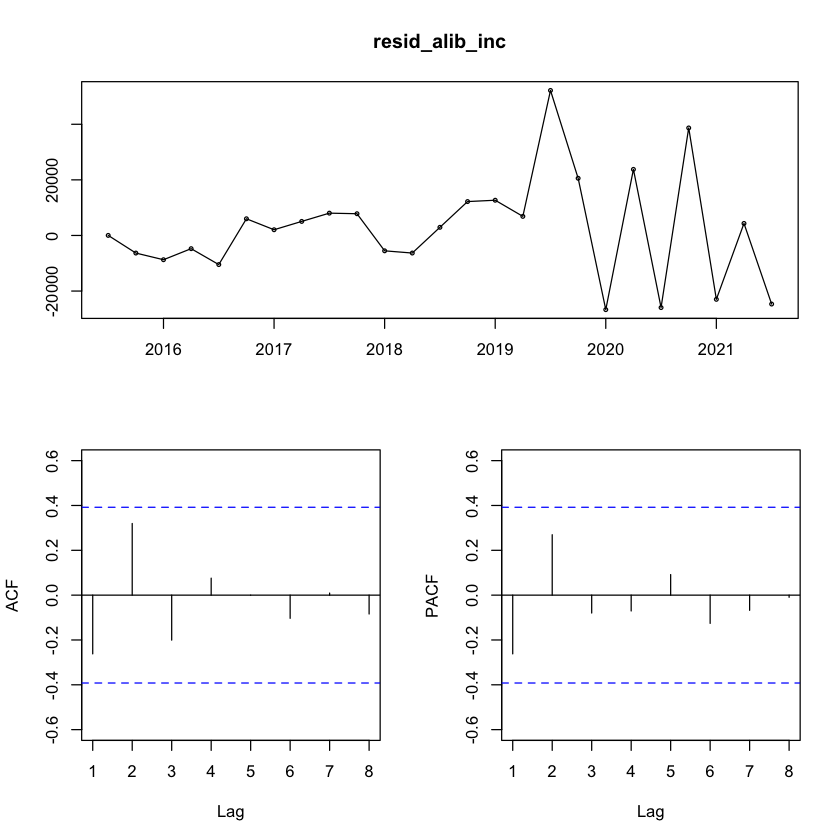

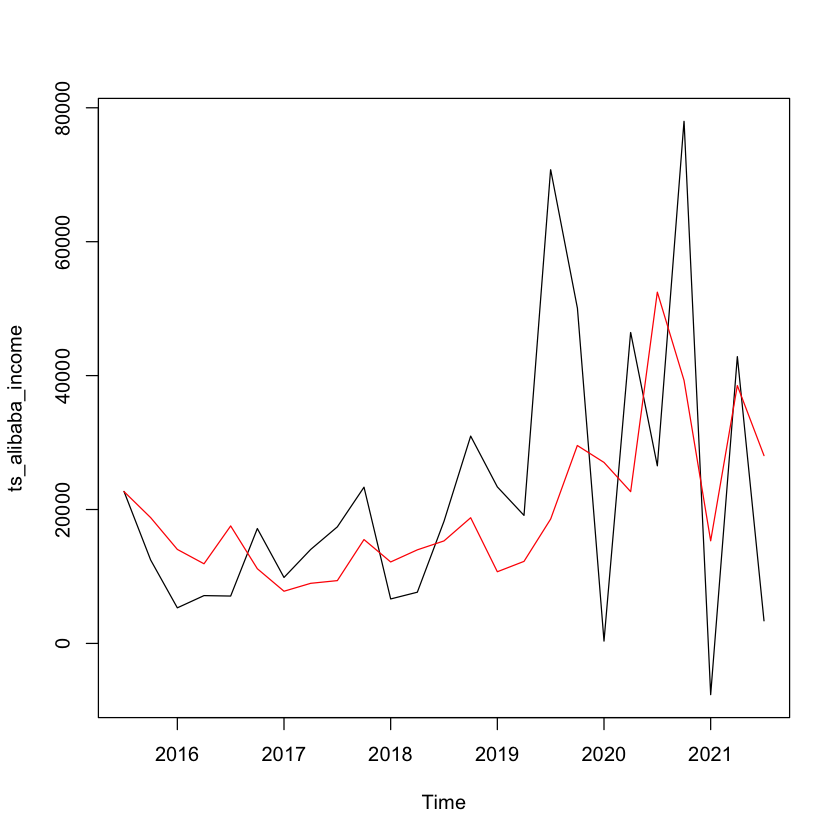

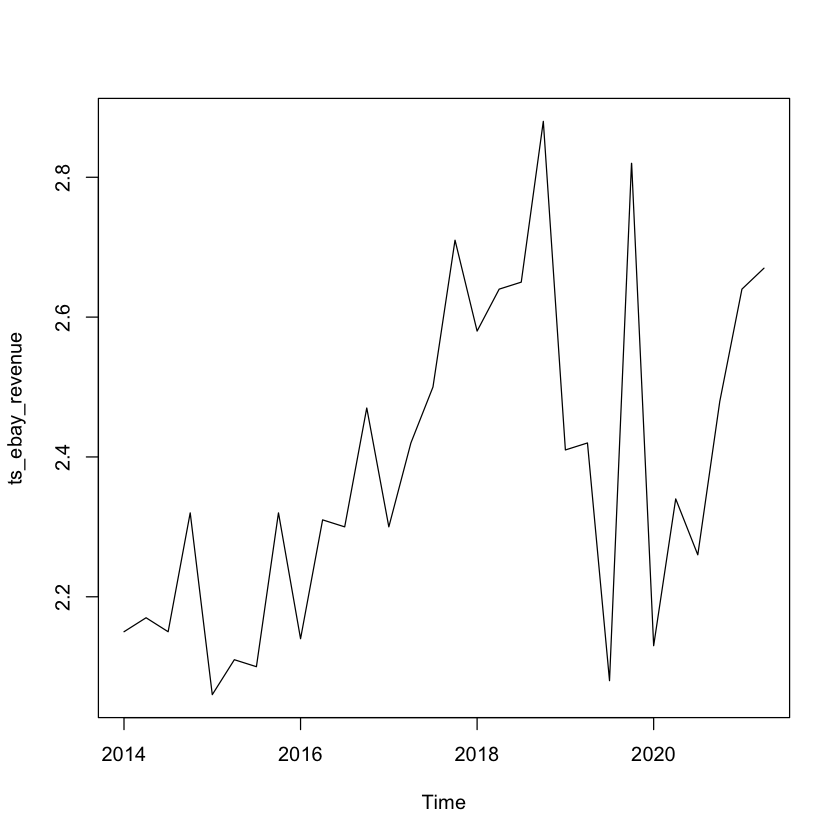

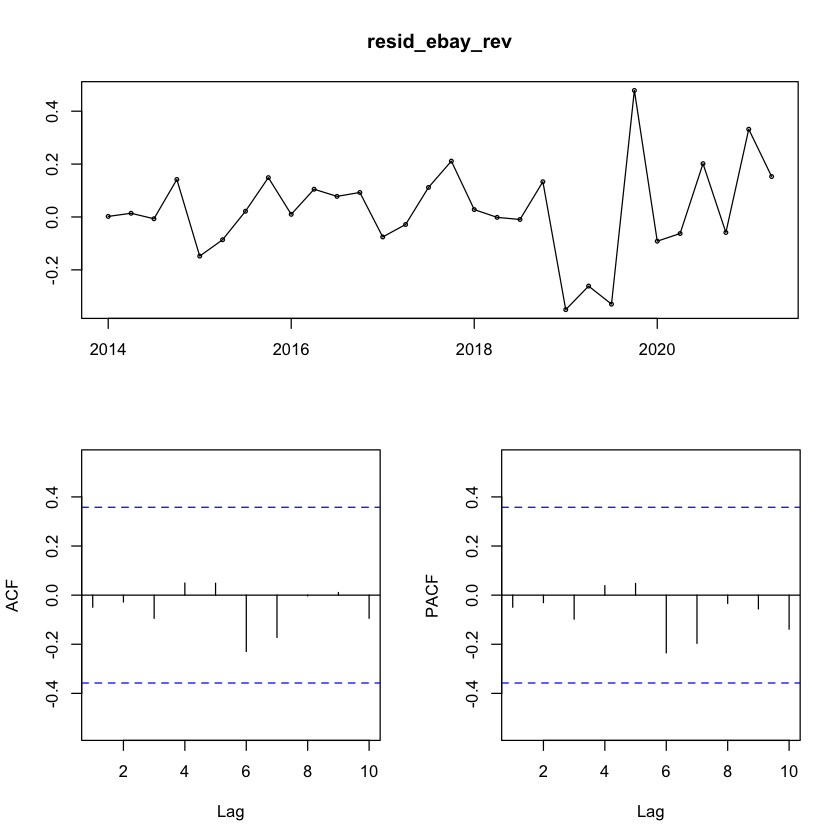

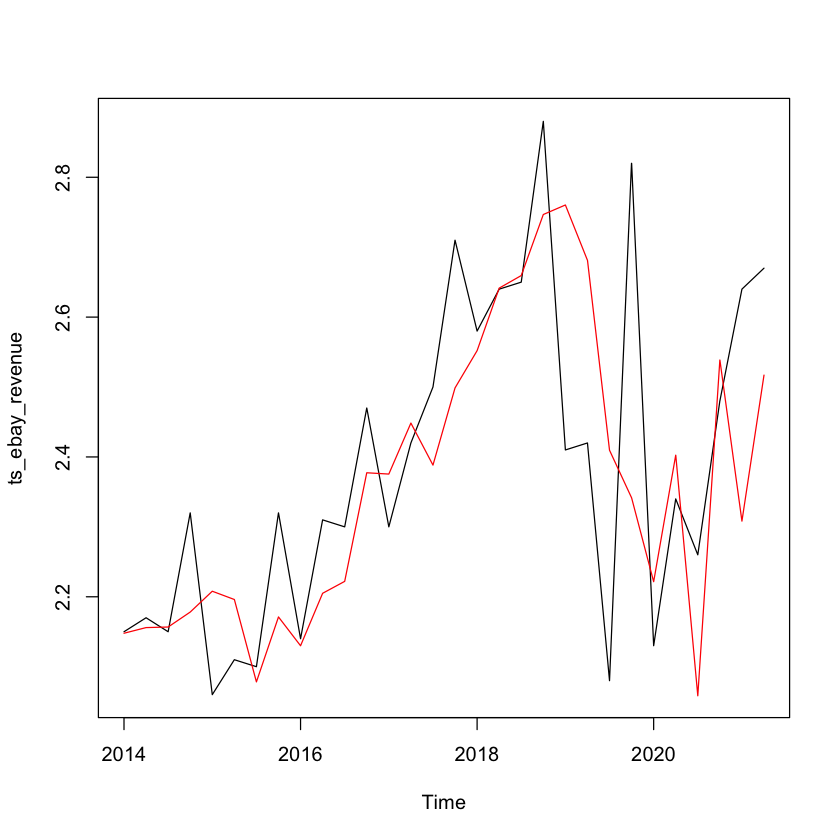

[1] " ALIBABA REVENUE"


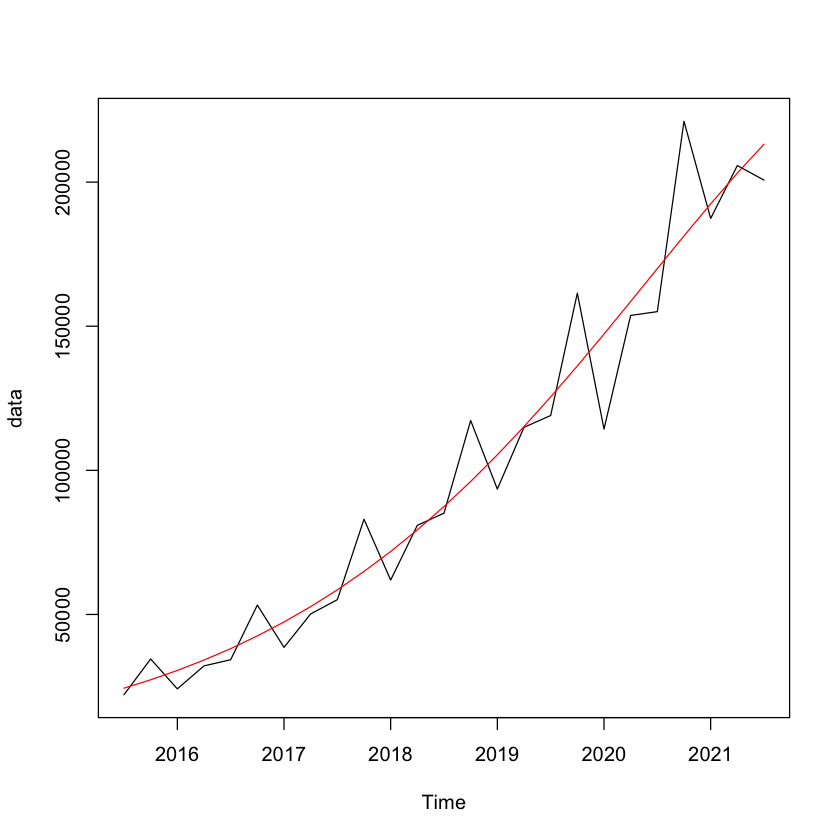

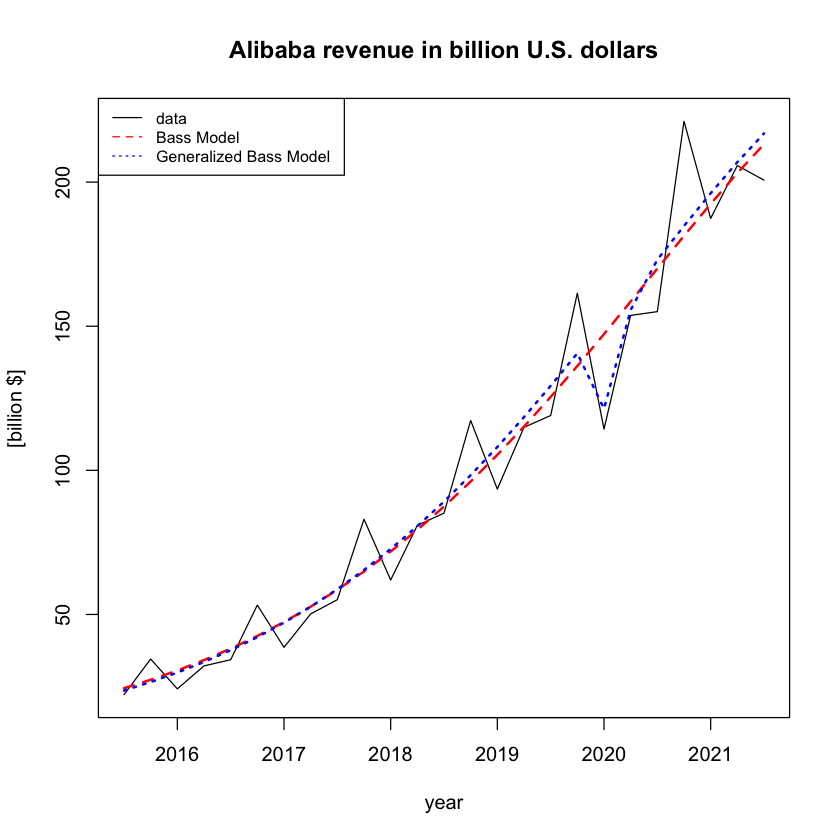

[1] 0.2864456
[1] " ALIBABA INCOME"


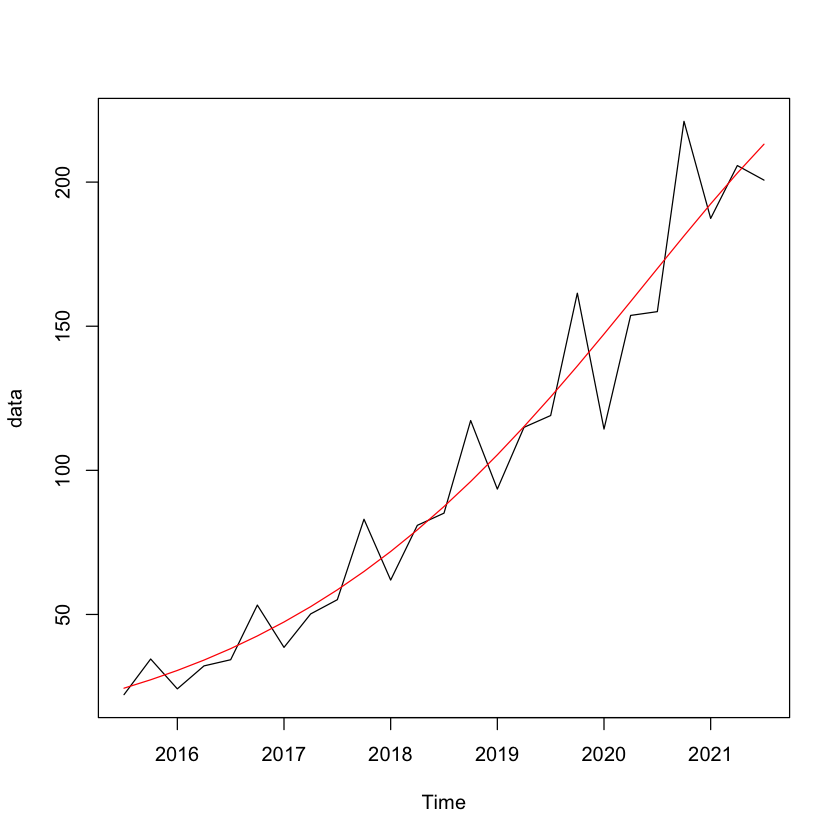

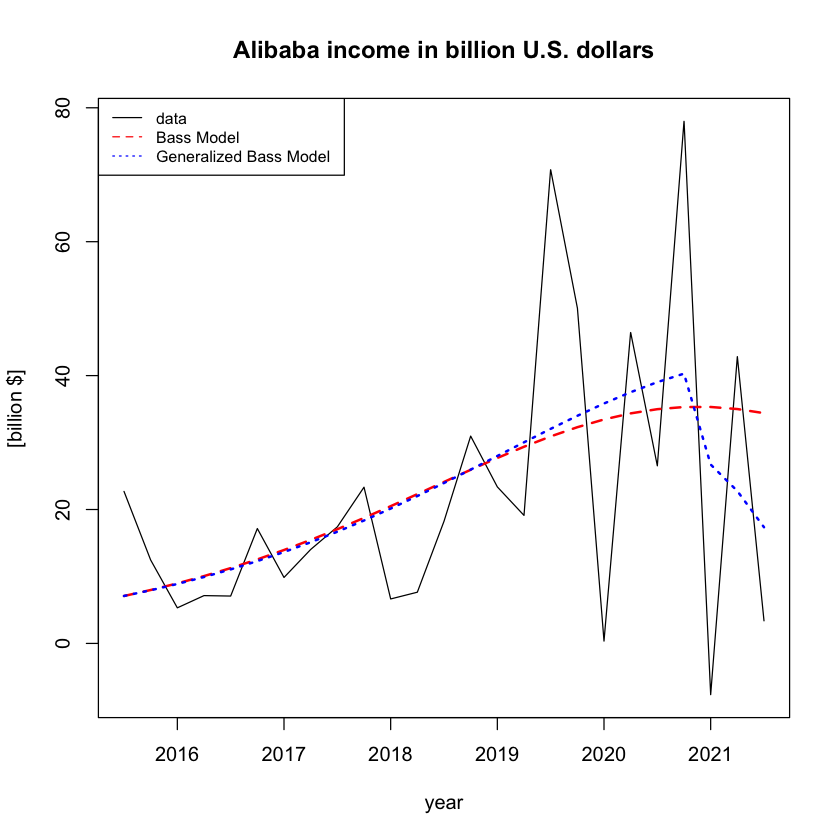

[1] 0.09814698


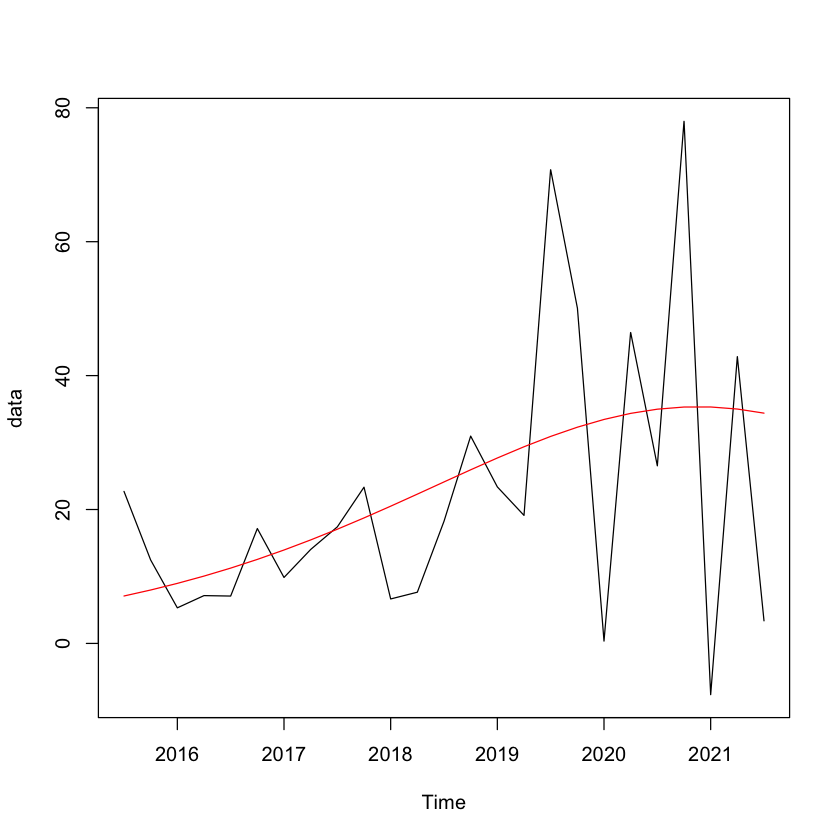

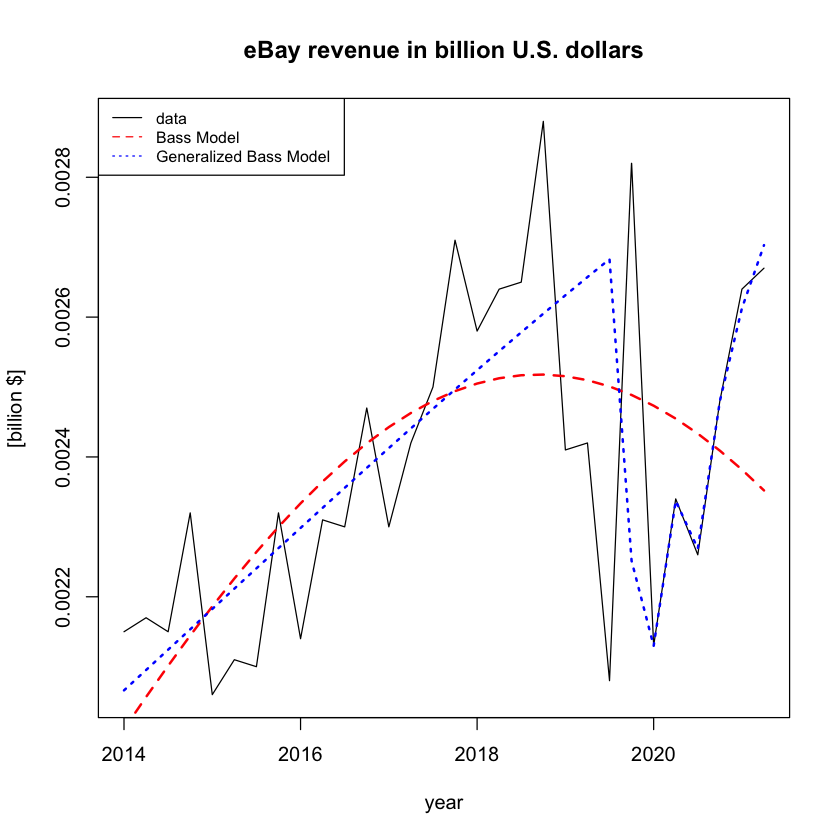

[1] 0.297221


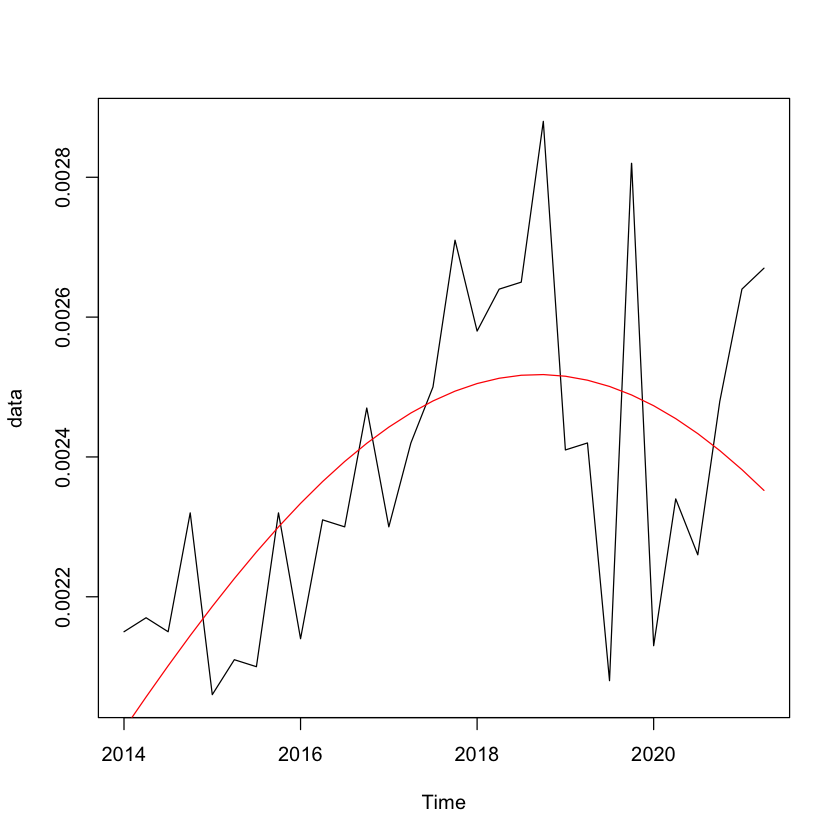

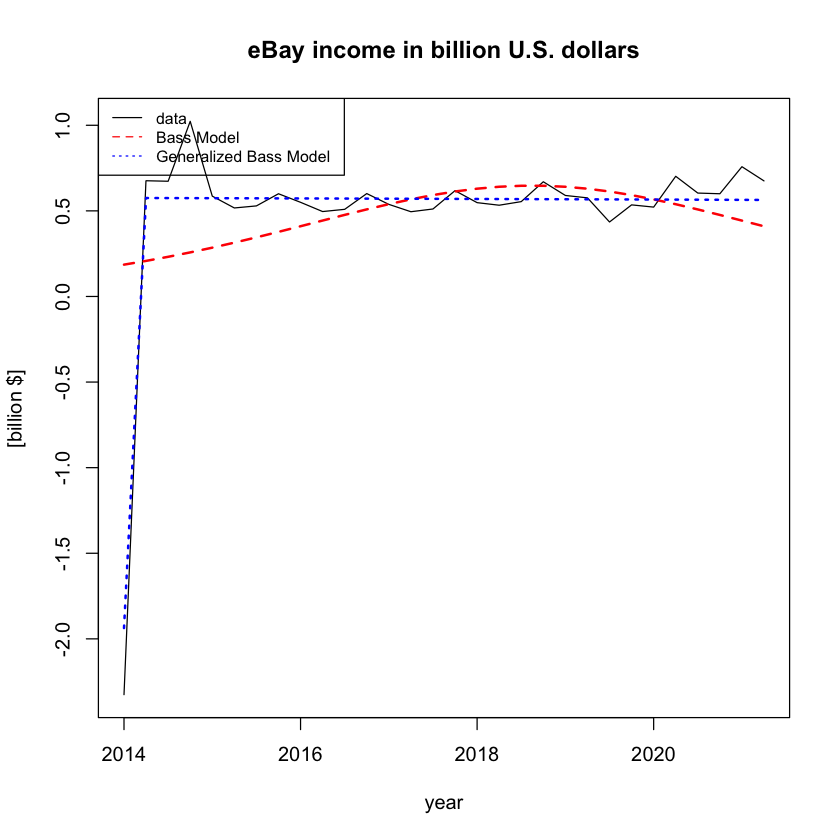

[1] 0.9394102
[1] " AMAZON INCOME"


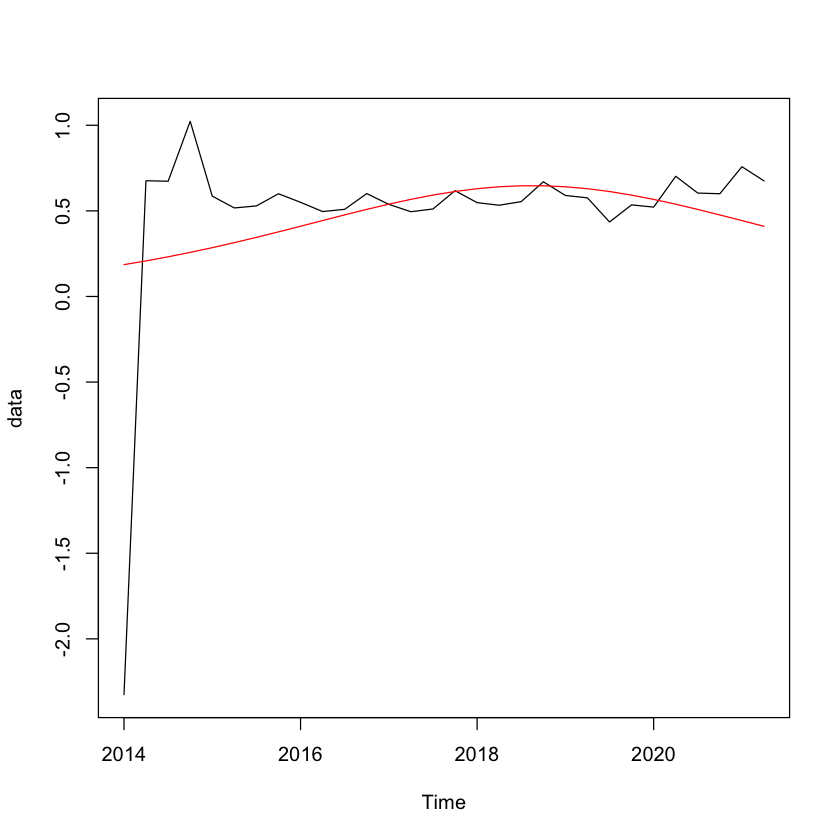

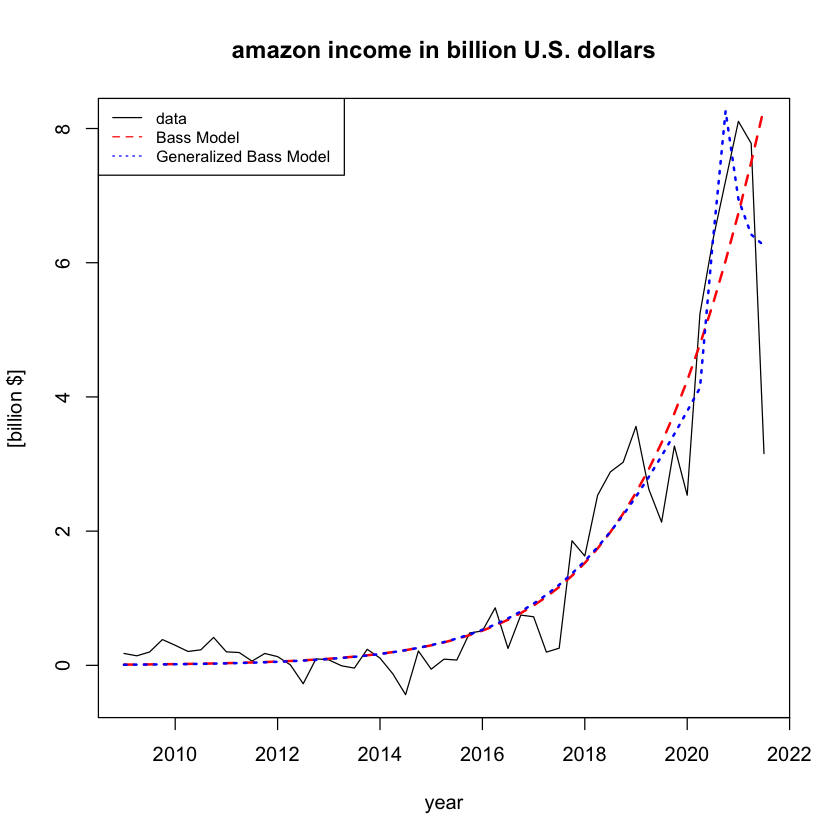

m             p             q            a1            b1   
 1.685339e+02  5.050408e-05  1.464046e-01  4.665039e+01 -8.611563e-01 
         c1   
 1.284610e+00

[1] 0.0487772
[1] "AMAZON REVENUE"


Warning message in nls.lm(par = prelimestimates, fn = ff1, t = t):
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


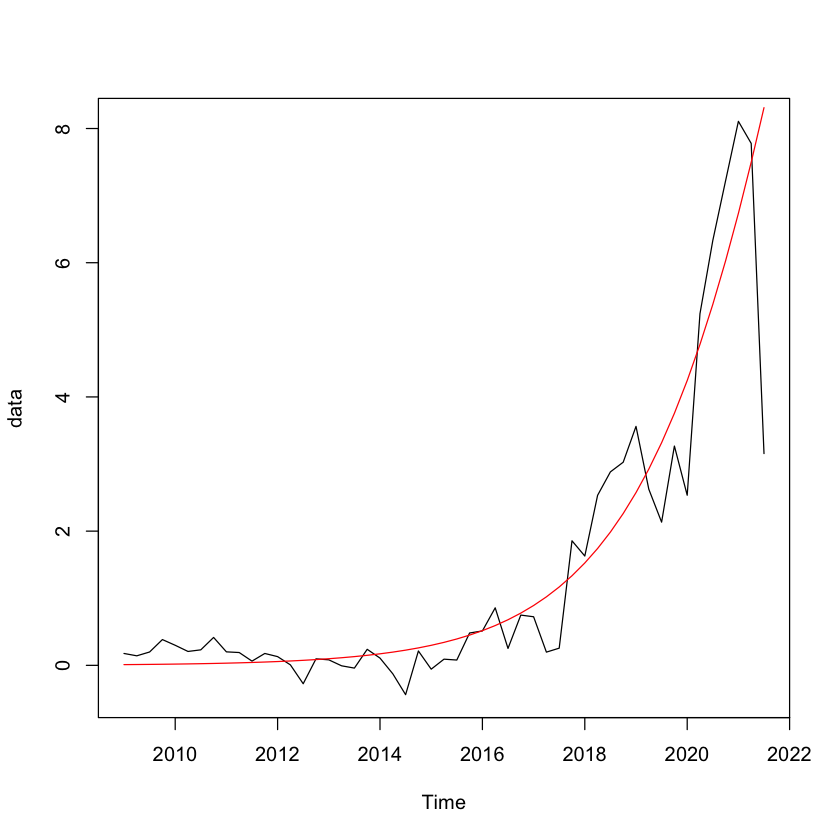

Warning message in nls.lm(par = prelimestimates, fn = ff1, t = t):
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


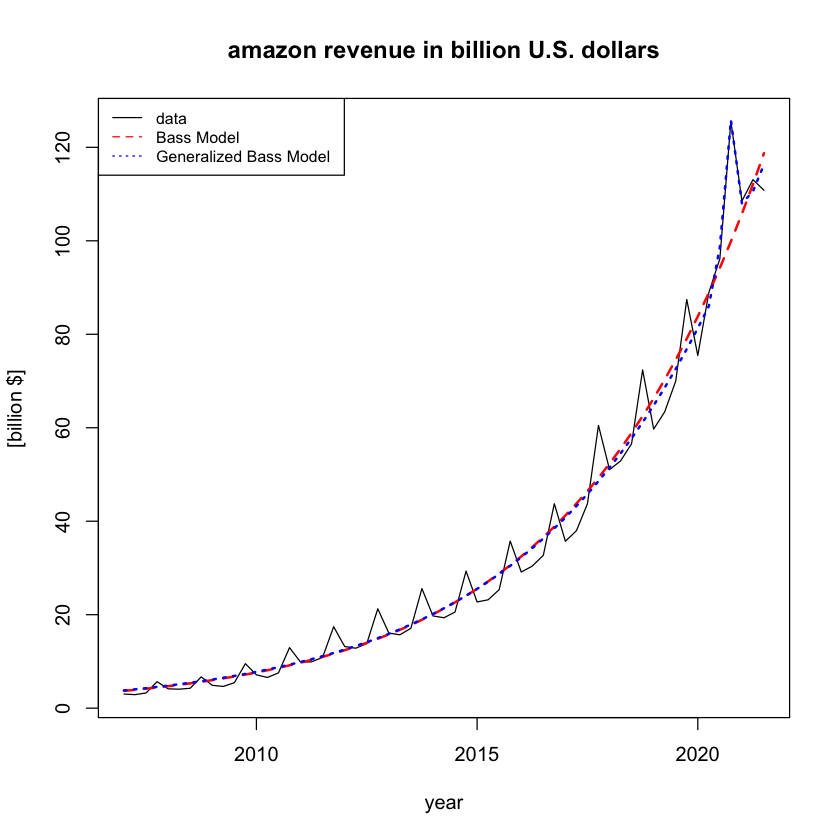

[1] 0.5255094


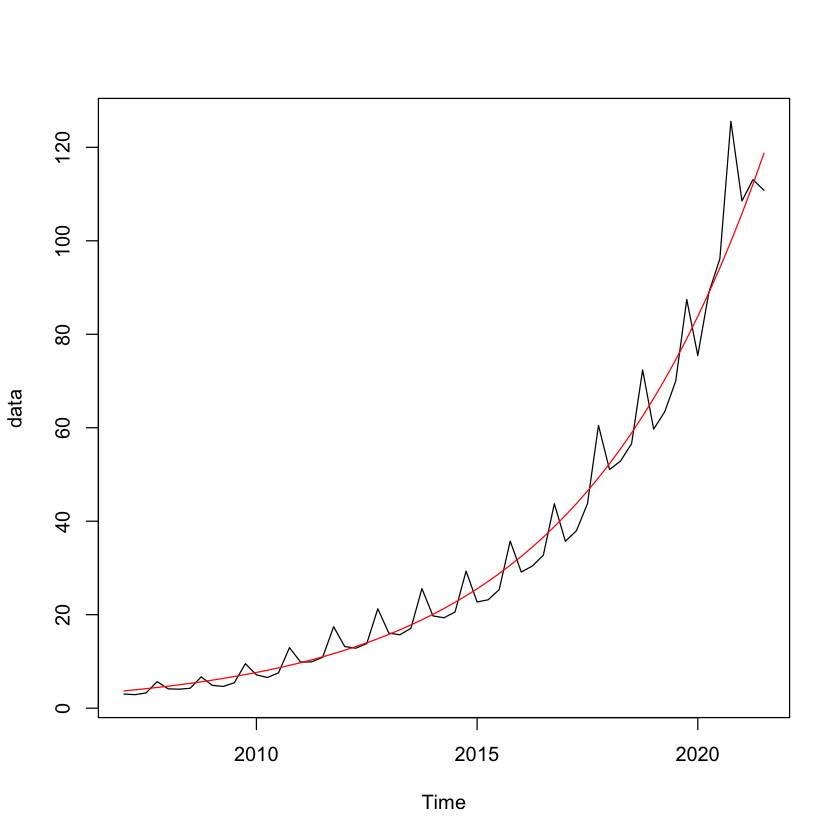

In [143]:




library(fpp2)
library(forecast)
library(lmtest)
library(DIMORA)
library(ggplot2)
library(lmtest)


alibaba_income <- read.csv('alibaba_income.csv', sep = ';')
alibaba_revenue <- read.csv('alibaba_revenue.csv', sep = ';')
amazon_income <- read.csv('amazon_income.csv', sep = ';')
amazon_revenue <- read.csv('amazon_revenue.csv', sep = ';')
ebay_income <- read.csv('ebay_income.csv', sep = ';')
ebay_revenue <- read.csv('ebay_revenue.csv', sep = ';')

ts_alibaba_income <- ts(data = alibaba_income$X, start = c(2015, 3), end = c(2021,3), frequency = 4)
ts_alibaba_revenue <- ts(data = alibaba_revenue$X, start = c(2015, 3), end = c(2021,3), frequency = 4)
ts_amazon_income <- ts(data = amazon_income$X, start = c(2009, 1), end = c(2021,3), frequency = 4)
ts_amazon_revenue <- ts(data = amazon_revenue$X, start = c(2007, 1), end = c(2021,3), frequency = 4)
ts_ebay_income <- ts(data = ebay_income$X, start = c(2014, 1), end = c(2021,2), frequency = 4)
ts_ebay_revenue <- ts(data = ebay_revenue$X, start = c(2014, 1), end = c(2021,2), frequency = 4)



###################### ALIBABA INCOME

plot(ts_alibaba_income)

arima_alib_inc <- auto.arima(ts_alibaba_income)

resid_alib_inc<- residuals(arima_alib_inc)
tsdisplay(resid_alib_inc)

plot(ts_alibaba_income)
lines(fitted(arima_alib_inc), col=2)
 
#################### EBAY REVENUE

plot(ts_ebay_revenue)

arima_ebay_rev<- auto.arima(ts_ebay_revenue)

resid_ebay_rev<- residuals(arima_ebay_rev)
tsdisplay(resid_ebay_rev)

plot(ts_ebay_revenue)
lines(fitted(arima_ebay_rev), col=2)


################ BASS ALIBABA REVENUE

BM_alibaba_rev <-  BM(ts_alibaba_revenue, 2015, 3, 2021, 3, 'Alibaba', 'revenue')
ts_res_BM_alibaba_rev <- ts(data =  BM_alibaba_rev$residuals, start = c(2015, 3), end = c(2021,3), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BM_alibaba_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))
SARIMA_BM_alibaba_rev <- SARIMA_GBM(ts_alibaba_revenue, 2015, 3, 2021, 3, BM_alibaba_rev, a[1:3], a[4:6]) 



################ BMG ALIBABA REVENUE (BEST)

print(' ALIBABA REVENUE')


ts_alibaba_revenue <- ts_alibaba_revenue/1000
GBM_alibaba_rev <-  GBM(ts_alibaba_revenue, 2015, 3, 2021, 3, 1, c(18,-1.2,-0.5), 'exp', 'Alibaba', 'revenue')

BM_alibaba_rev <- BM(ts_alibaba_revenue, 2015, 3, 2021, 3, 'Alibaba', 'revenue') 
R_alibaba_rev <- R_nested_models(BM_alibaba_rev, GBM_alibaba_rev)
print(R_alibaba_rev)
ts_res_BMG_alibaba_rev <- ts(data =  GBM_alibaba_rev$residuals, start = c(2015, 3), end = c(2021,3), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_alibaba_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))
SARIMA_GBM_alibaba_rev <- SARIMA_GBM(ts_alibaba_revenue, 2015, 3, 2021, 3, GBM_alibaba_rev, a[1:3], a[4:6]) 
SARIMA_BM_alibaba_rev <- SARIMA_GBM(ts_alibaba_revenue, 2015, 3, 2021, 3, BM_alibaba_rev, a[1:3], a[4:6]) 





################ BMG ALIBABA INCOME
print(' ALIBABA INCOME')

ts_alibaba_income <- ts_alibaba_income/1000

GBM_alibaba_inc <-  GBM(ts_alibaba_income, 2015, 3, 2021, 3, 1, c(22, -1.8, -4), 'exp',  'Alibaba', 'income')
BM_alibaba_inc <-  BM(ts_alibaba_income, 2015, 3, 2021, 3,  'Alibaba', 'income')
R_alibaba_inc <- R_nested_models(BM_alibaba_inc, GBM_alibaba_inc)
print(R_alibaba_inc)
ts_res_BMG_alibaba_inc <- ts(data =  GBM_alibaba_inc$residuals, start = c(2015, 3), end = c(2021,3), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_alibaba_inc, seasonal = T, stepwise=FALSE, approximation=FALSE))
SARIMA_GBM_alibaba_inc <- SARIMA_GBM(ts_alibaba_income, 2015, 3, 2021, 3,  GBM_alibaba_inc,a[1:3], c(0,0,0)) 
SARIMA_BM_alibaba_inc <- SARIMA_GBM(ts_alibaba_income, 2015, 3, 2021, 3,  BM_alibaba_inc,a[1:3], c(0,0,0)) 





############# BMG EBAY REVENUE

ts_ebay_revenue <- ts_ebay_revenue/1000

GBM_ebay_rev <-  GBM(ts_ebay_revenue, 2014, 1, 2021, 2, 2, c(20, -0.1,-0.1, 24, -0.1,-0.1), 'exp', 'eBay', 'revenue')
BM_ebay_rev <-  BM(ts_ebay_revenue, 2014, 1, 2021, 2, 'eBay', 'revenue')
R_ebay_rev <- R_nested_models(BM_ebay_rev, GBM_ebay_rev)
print(R_ebay_rev)

ts_res_BMG_ebay_rev <- ts(data =  GBM_ebay_rev$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_ebay_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))
SARIMA_GBM_ebay_rev <- SARIMA_GBM(ts_ebay_revenue, 2014, 1, 2021, 2,  GBM_ebay_rev, a[1:3], c(0,0,0)) 
SARIMA_BM_ebay_rev <- SARIMA_GBM(ts_ebay_revenue, 2014, 1, 2021, 2,  BM_ebay_rev, a[1:3], c(0,0,0)) 





############## BMG EBAY INCOME
ts_ebay_income = ts_ebay_income/1000

GBM_ebay_inc <-  GBM(ts_ebay_income, 2014, 1, 2021, 2, 1, c(1, -0.3, -6), 'exp', 'eBay', 'income')
BM_ebay_inc <-  BM(ts_ebay_income, 2014, 1, 2021, 2, 'eBay', 'income')
R_ebay_inc <- R_nested_models(BM_ebay_inc, GBM_ebay_inc)
print(R_ebay_inc)
ts_res_BMG_ebay_inc <- ts(data =  GBM_ebay_inc$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_ebay_inc, seasonal = T, stepwise=FALSE, approximation=FALSE, D=1))
SARIMA_GBM_ebay_inc <- SARIMA_GBM(ts_ebay_income, 2014, 1, 2021, 2,  GBM_ebay_inc, a[1:3], c(0,0,0)) 
SARIMA_BM_ebay_inc <- SARIMA_GBM(ts_ebay_income, 2014, 1, 2021, 2,  BM_ebay_inc, a[1:3], c(0,0,0)) 






################ BMG AMAZON INCOME
print(' AMAZON INCOME')

ts_amazon_income <- ts_amazon_income/1000

GBM_amazon_inc <-  GBM(ts_amazon_income, 2009, 1, 2021, 3, 1, c(44,-0.3,0.2), 'exp', 'amazon', 'income')
BM_amazon_inc <-  BM(ts_amazon_income, 2009, 1, 2021, 3, 'amazon', 'income')
GBM_amazon_inc$coefficients

R_amazon_inc <- R_nested_models(BM_amazon_inc, GBM_amazon_inc)
print(R_amazon_inc)

ts_res_BMG_amazon_inc <- ts(data =  GBM_amazon_inc$residuals, start = c(2007, 1), end = c(2021,3), frequency = 4)
#a <- arimaorder(auto.arima(ts_res_BMG_amazon_inc, seasonal = T, stepwise=FALSE, approximation=FALSE, D=0))
#i put the following parameter since auto.arima was not able to predict the best ones 
#higher AIC and residusals obtained with SARIMA were not white noise
#the selected values has been inferred by looking at the time series ts_res_BMG_amazon_inc
#since sarma.refinement works with residuals
SARIMA_GBM_amazon_inc <- SARIMA_GBM(ts_amazon_income, 2009, 1, 2021, 3,  GBM_amazon_inc, c(0,1,5), c(1,0,0)) 
SARIMA_BM_amazon_inc <- SARIMA_GBM(ts_amazon_income, 2009, 1, 2021, 3,  BM_amazon_inc, c(0,1,5), c(1,0,0)) 






################ BMG AMAZON REVENUE
print('AMAZON REVENUE')


GBM_amazon_rev <-  GBM(ts_amazon_revenue, 2007, 1, 2021, 3, 1, c(50,-0.3,0.2), 'exp', 'amazon', 'revenue')
BM_amazon_rev <-  BM(ts_amazon_revenue, 2007, 1, 2021, 3, 'amazon', 'revenue')

R_amazon_rev <-R_nested_models(BM_amazon_rev, GBM_amazon_rev)
print(R_amazon_rev)


ts_res_BMG_amazon_rev <- ts(data =  GBM_amazon_rev$residuals, start = c(2007, 1), end = c(2021,3), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_amazon_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))
SARIMA_GBM_amazon_rev <- SARIMA_GBM(ts_amazon_revenue, 2007, 1, 2021, 3,  GBM_amazon_rev, a[1:3], a[4:6]) 
SARIMA_BM_amazon_rev <- SARIMA_GBM(ts_amazon_revenue, 2007, 1, 2021, 3,  BM_amazon_rev, a[1:3], a[4:6]) 




In [141]:


ts_amazon_income <- ts(data = amazon_income$X, start = c(2015, 3), end = c(2021,3), frequency = 4)
################ BMG AMAZON REVENUE


print(' AMAZON INCOME')

ts_amazon_income <- ts_amazon_income/1000

GBM_amazon_inc <-  GBM(ts_amazon_income, 2009, 1, 2021, 3, 1, c(44,-0.3,0.2), 'exp', 'amazon', 'income')
GBM_amazon_inc$coefficients
BM_amazon_inc <-  BM(ts_amazon_income, 2009, 1, 2021, 3, 'amazon', 'income')

R_amazon_inc <- R_nested_models(BM_amazon_inc, GBM_amazon_inc)
print(R_amazon_inc)

ts_res_BMG_amazon_inc <- ts(data =  GBM_amazon_inc$residuals, start = c(2007, 1), end = c(2021,3), frequency = 4)
#a <- arimaorder(auto.arima(ts_res_BMG_amazon_inc, seasonal = T, stepwise=FALSE, approximation=FALSE, D=0))
#i put the following parameter since auto.arima was not able to predict the best ones 
#higher AIC and residusals obtained with SARIMA were not white noise
#the selected values has been inferred by looking at the time series ts_res_BMG_amazon_inc
#since sarma.refinement works with residuals
SARIMA_GBM_amazon_inc <- SARIMA_GBM(ts_amazon_income, 2009, 1, 2021, 3,  GBM_amazon_inc, c(0,1,5), c(1,0,0)) 
SARIMA_BM_amazon_inc <- SARIMA_GBM(ts_amazon_income, 2009, 1, 2021, 3,  BM_amazon_inc, c(0,1,5), c(1,0,0)) 





[1] " AMAZON INCOME"


Warning message in nls.lm(par = prelimestimates, fn = ff1, t = t):
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


ERROR: Error in chol.default(object$hessian): il minore principale di ordine 4 non è definito positivo


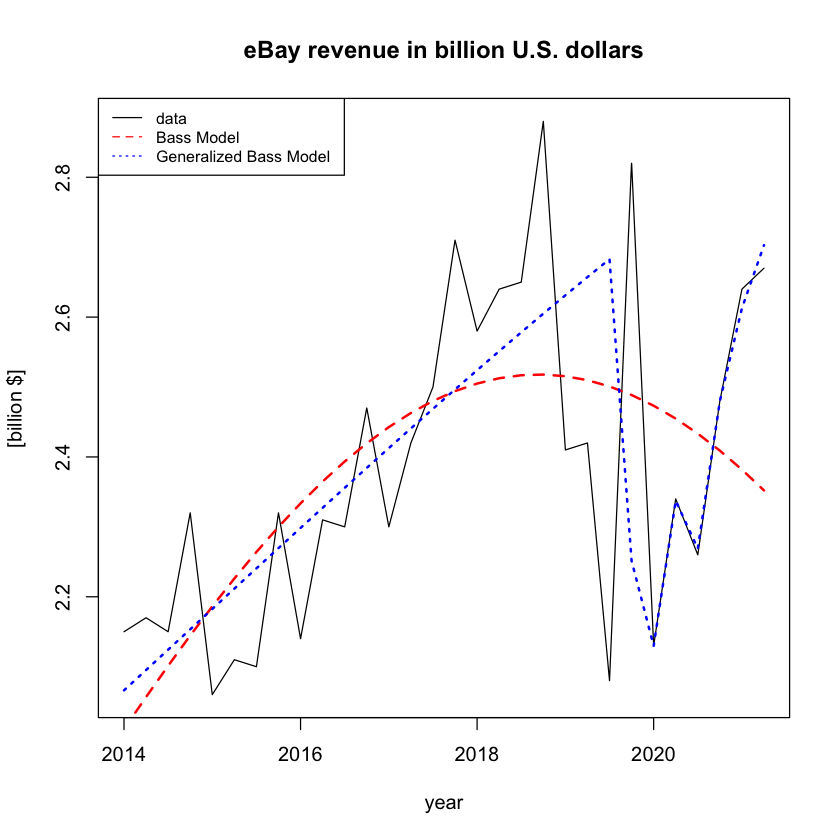

[1] 0.2972207
p d q 
0 0 2 


pdf 
  2

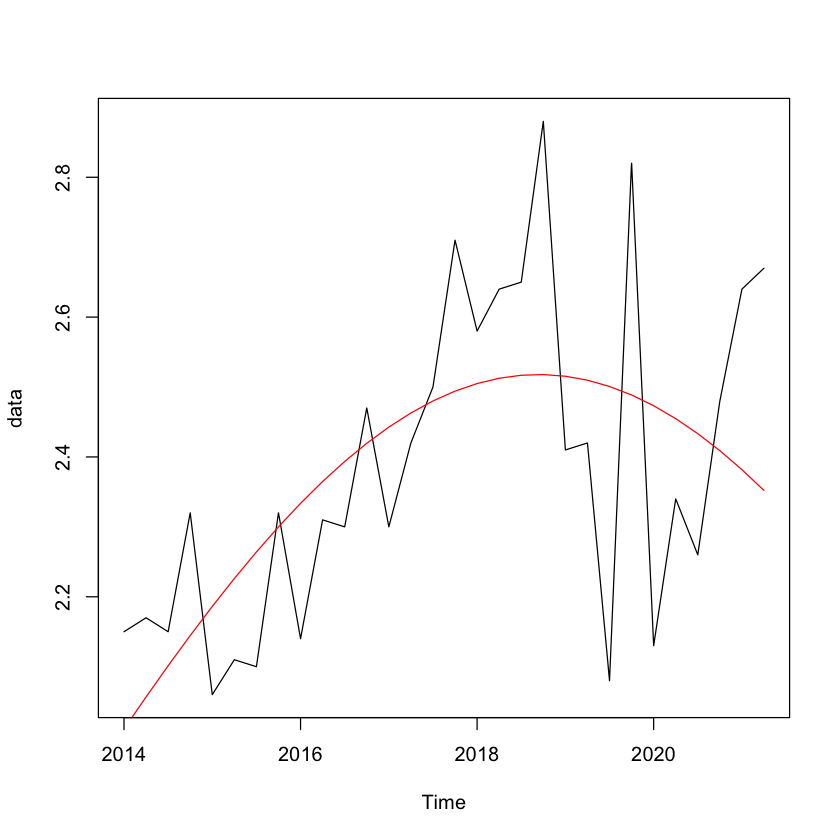

In [162]:
############# BMG EBAY REVENUE
ts_ebay_revenue <- ts(data = ebay_revenue$X, start = c(2014, 1), end = c(2021,2), frequency = 4)


#ts_ebay_revenue <- ts_ebay_revenue/1000

GBM_ebay_rev <-  GBM(ts_ebay_revenue, 2014, 1, 2021, 2, 2, c(20, -0.1,-0.1, 24, -0.1,-0.1), 'exp', 'eBay', 'revenue')
BM_ebay_rev <-  BM(ts_ebay_revenue, 2014, 1, 2021, 2, 'eBay', 'revenue')
R_ebay_rev <- R_nested_models(BM_ebay_rev, GBM_ebay_rev)
print(R_ebay_rev)

ts_res_BMG_ebay_rev <- ts(data =  GBM_ebay_rev$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_ebay_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))
print(a)
SARIMA_GBM_ebay_rev <- SARIMA_GBM(ts_ebay_revenue, 2014, 1, 2021, 2,  GBM_ebay_rev, a[1:3], c(0,1, 0)) 
#SARIMA_BM_ebay_rev <- SARIMA_GBM(ts_ebay_revenue, 2014, 1, 2021, 2,  BM_ebay_rev, a[1:3], a[4:6]) 


plotting(ts_ebay_revenue, BM_ebay_rev, GBM_ebay_rev, SARIMA_GBM_ebay_rev, 2014, 1, 2021, 2, 'eBay', 'revenue', ' G. Bass model')






m             p             q            a1            b1   
241.619676549   0.002376099   0.001766135 -27.085497499  -0.602913574 
         c1   
 -2.634859017

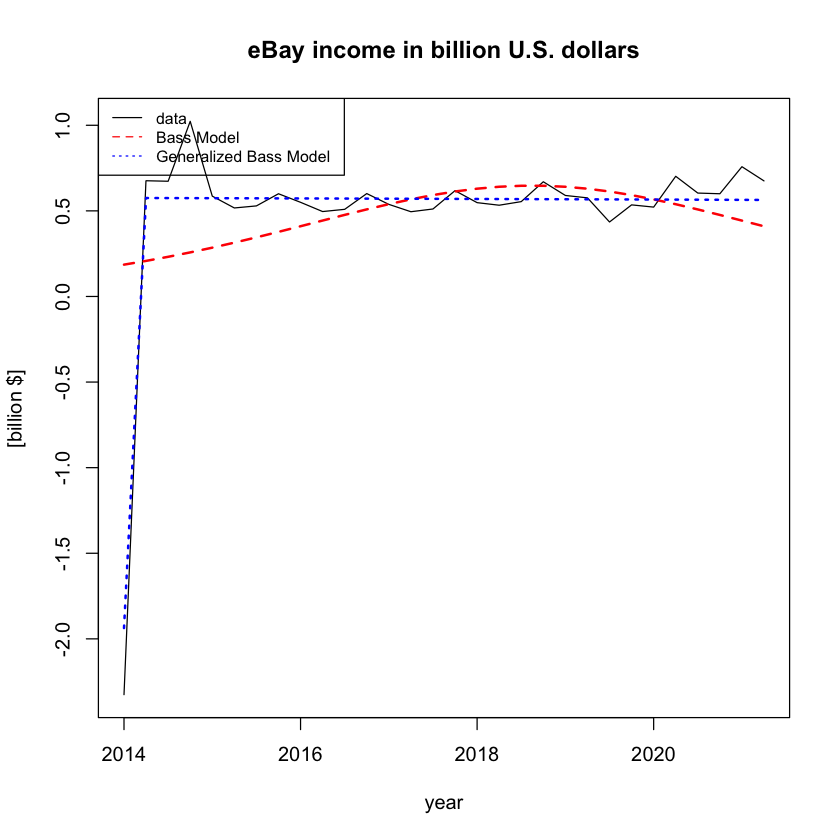

[1] 0.9394102
p d q 
2 0 0 


pdf 
  2

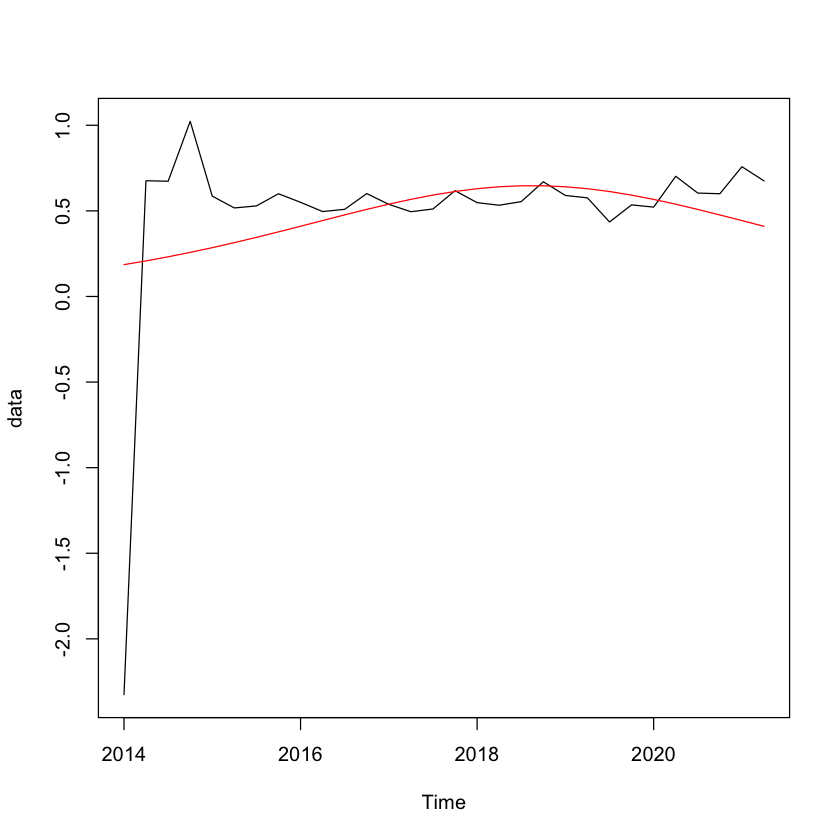

In [188]:
############## BMG EBAY INCOME
ts_ebay_income <- ts(data = ebay_income$X, start = c(2014, 1), end = c(2021,2), frequency = 4)


ts_ebay_income = ts_ebay_income/1000

GBM_ebay_inc <-  GBM(ts_ebay_income, 2014, 1, 2021, 2, 1, c(1, -0.3, -6), 'exp', 'eBay', 'income')
GBM_ebay_inc$coefficients
BM_ebay_inc <-  BM(ts_ebay_income, 2014, 1, 2021, 2, 'eBay', 'income')
R_ebay_inc <- R_nested_models(BM_ebay_inc, GBM_ebay_inc)
print(R_ebay_inc)
ts_res_GBM_ebay_inc <- ts(data =  GBM_ebay_inc$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)
ts_res_BM_ebay_inc <- ts(data =  BM_ebay_inc$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)


a <- arimaorder(auto.arima(ts_res_GBM_ebay_inc, seasonal = T, stepwise=FALSE, approximation=FALSE))
print(a)
SARIMA_GBM_ebay_inc <- SARIMA_GBM(ts_ebay_income, 2014, 1, 2021, 2,  GBM_ebay_inc, a[1:3], c(0,2, 3)) 
SARIMA_BM_ebay_inc <- SARIMA_GBM(ts_ebay_income, 2014, 1, 2021, 2,  BM_ebay_inc, a[1:3], c(0, 2, 3)) 

#(data, BM, GBM, SARIMA, y0, q0, yf, qf, company, quantity, best_model) 
plotting(ts_ebay_income, BM_ebay_inc, GBM_ebay_inc, SARIMA_GBM_ebay_inc, 2014, 1, 2021, 2, 'eBay', 'income', ' Generalized Bass model')





In [9]:
#(data, BM, GBM, SARIMA, y0, q0, yf, qf, company, quantity, best_model) 
plotting(ts_amazon_revenue, BM_amazon_rev, GBM_amazon_rev, SARIMA_GBM_amazon_rev, 2007, 1, 2021, 3, 'Amazon', 'revenue', 'Generalized Bass model')



pdf 
  2

In [10]:
#(data, BM, GBM, SARIMA, y0, q0, yf, qf, company, quantity, best_model) 
plotting(ts_amazon_income, BM_amazon_inc, GBM_amazon_inc, SARIMA_BM_amazon_inc, 2009, 1, 2021, 3, 'Amazon', 'income', 'Bass model')




pdf 
  2

In [11]:
#(data, BM, GBM, SARIMA, y0, q0, yf, qf, company, quantity, best_model) 
plotting(ts_alibaba_revenue, BM_alibaba_rev, GBM_alibaba_rev, SARIMA_GBM_alibaba_rev, 2015, 3, 2021, 3, 'alibaba', 'revenue', ' Generalized Bass model')





pdf 
  2

In [12]:
#(data, BM, GBM, SARIMA, y0, q0, yf, qf, company, quantity, best_model) 
plotting(ts_alibaba_income, BM_alibaba_inc, GBM_alibaba_inc, SARIMA_BM_alibaba_inc, 2015, 3, 2021, 3, 'alibaba', 'income', ' Bass model')






pdf 
  2

Warning message in nls.lm(par = prelimestimates, fn = ff1, t = t):
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


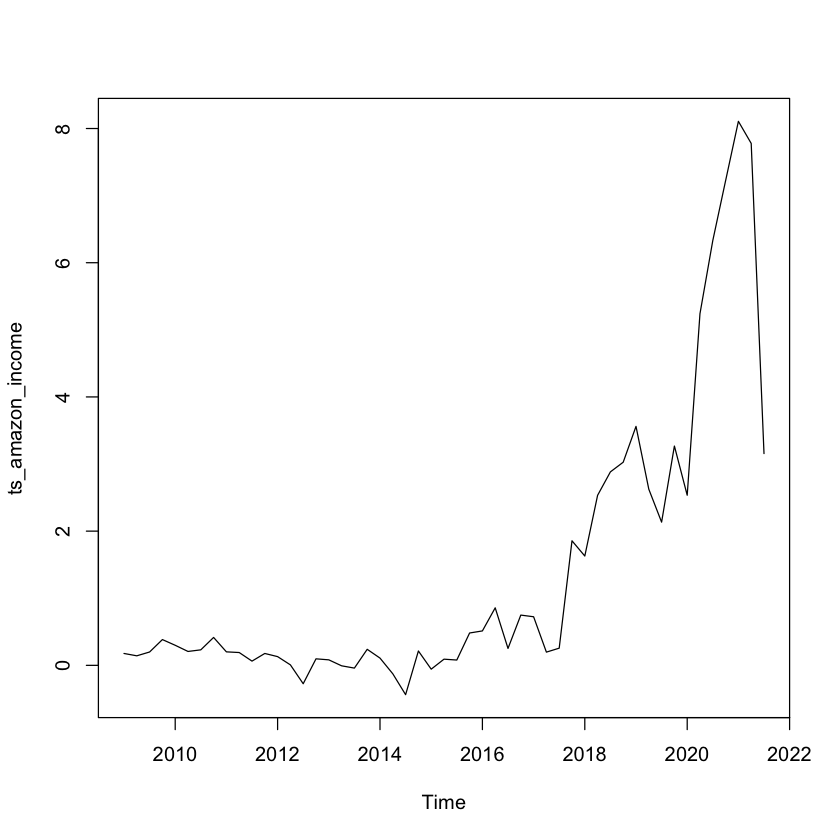

pdf 
  2

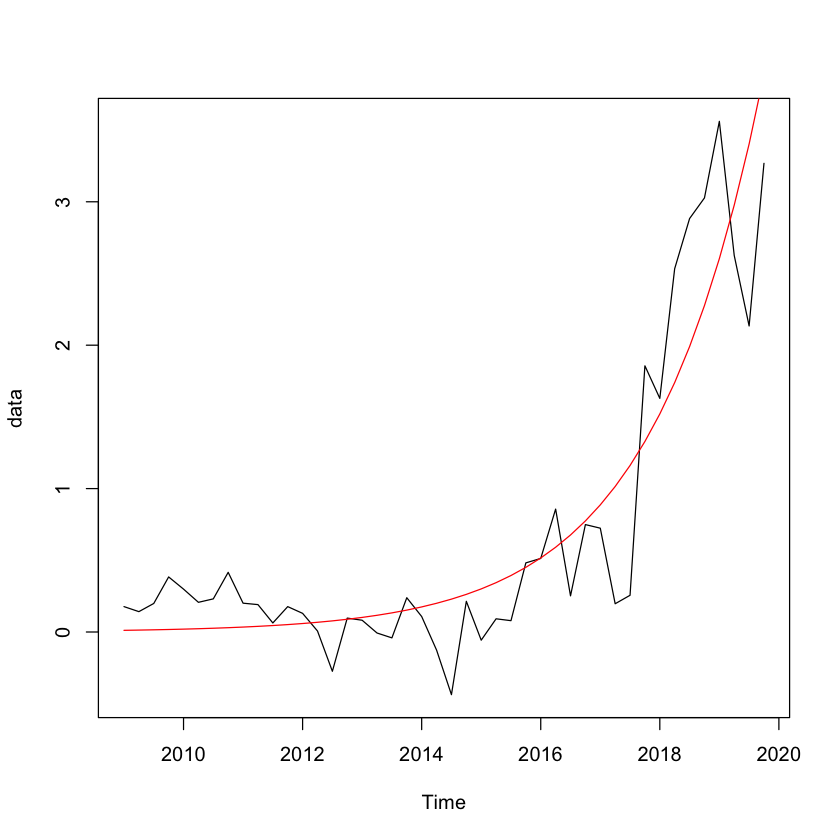

In [34]:
plot(ts_amazon_income)
ts_new <- ts(data=ts_amazon_income[1:44], start=c(2009, 1), end=c(2019, 4), frequency = 4)
BM_amazon_inc_no_covid <-  BM(ts_new, 2009, 1, 2019, 4, 'amazon', 'income')
fit_BM <- ts(data=fitted(BM_amazon_inc), start=c(2009, 1), end=c(2019, 4), frequency = 4)
ts_res_BM_amazon_inc <- ts(data =  BM_amazon_inc_no_covid$residuals, start = c(2009, 1), end = c(2019, 4), frequency = 4)

a <- arimaorder(auto.arima(ts_res_BM_amazon_inc, seasonal = T, stepwise=FALSE, approximation=FALSE))


SARIMA_BM_amazon_inc <- SARIMA_GBM(ts_new, 2009, 1, 2019, 4,  BM_amazon_inc_no_covid, a[1:3], a[4:6]) 



    
    
fit_arima_BM <-fitted(SARIMA_BM_amazon_inc)


filename = paste('plots/predictions_amazon_income_NO_COVID.png', sep = "")
png(filename, res=100)   


plot(forecast(SARIMA_BM_amazon_inc, 
              xreg = predict(BM_amazon_inc_no_covid, newx = 45:51)), 
     #ylim=c(0, 130),
     xlab='year', 
     ylab='[billion U.S. $]',
     main='Amazon income: \n predictions without COVID-19 epidemic'
    )
lines(ts_amazon_income, type='o', col='black')
lines(fit_arima_BM, col='blue', lty=3, lwd=3)
legend('topleft', legend=c("predictions", "observed data", "Bass Model+SARIMA"),
       col=c('blue', 'black', 'blue'), lwd=c(3,1,3), lty=c(1,1,3),  pch = c(NA, 1, NA), cex=0.8)
dev.off()

pdf 
  2

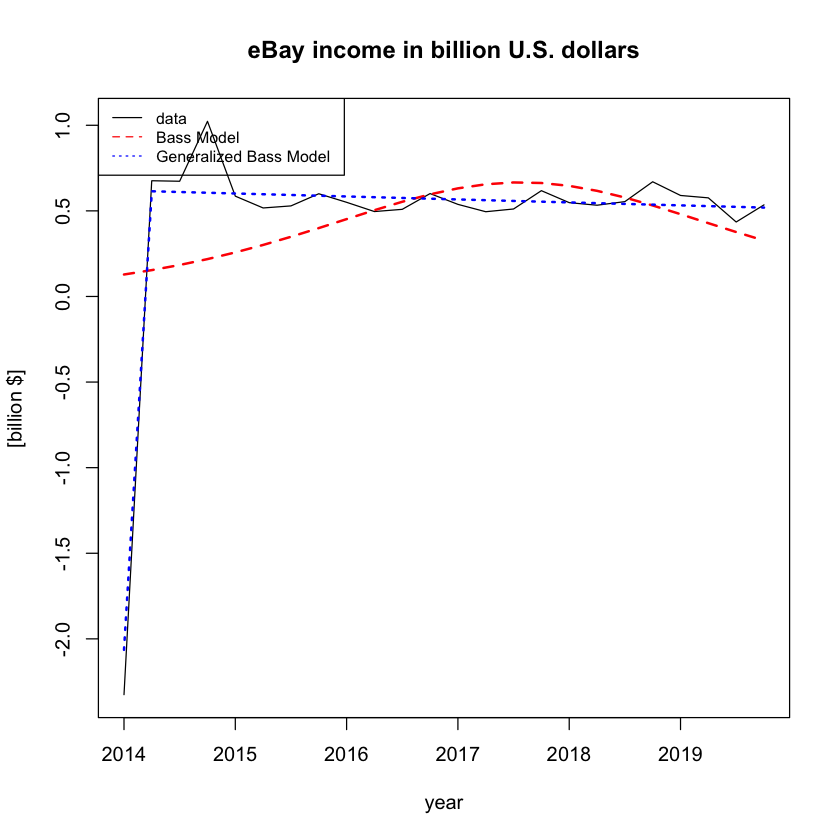

In [179]:
ts_new <- ts(data=ts_ebay_income[1:24], start=c(2014, 1), end=c(2019, 4), frequency = 4)
#BM_ebay_inc_no_covid <-  BM(ts_new, 2014, 1, 2019, 4, 'ebay', 'income')
GBM_ebay_inc_no_covid <-  GBM(ts_new, 2014, 1, 2019, 4, 1, c(1, -0.3, -6), 'exp', 'eBay', 'income')
#fit_GBM <- ts(data=fitted(GBM_ebay_inc_no_covid), start=c(2014, 1), end=c(2019, 4), frequency = 4)
ts_res_GBM_ebay_inc <- ts(data =  GBM_ebay_inc_no_covid$residuals, start = c(2014, 1), end = c(2019, 4), frequency = 4)

a <- arimaorder(auto.arima(ts_res_GBM_ebay_inc, seasonal = T, stepwise=FALSE, approximation=FALSE))


SARIMA_GBM_ebay_inc <- SARIMA_GBM(ts_new, 2014, 1, 2019, 4,  GBM_ebay_inc_no_covid, a[1:3],  c(0,2,3)) 
fit_arima_GBM <-fitted(SARIMA_GBM_ebay_inc)



filename = paste('plots/predictions_ebay_income_NO_COVID.png', sep = "")
png(filename, res=100)   


plot(forecast(SARIMA_GBM_ebay_inc, 
              xreg = predict(GBM_ebay_inc_no_covid, newx = 25:30)), 
     #ylim=c(0, 130),
     xlab='year', 
     ylab='[billion U.S. $]',
     main='ebay income: \n predictions without COVID-19 epidemic'
    )
lines(ts_ebay_income, type='o', col='black')
lines(fit_arima_GBM, col='blue', lty=3, lwd=3)
legend('bottomright', legend=c("predictions", "observed data", "Bass Gen. Model+SARIMA"),
       col=c('blue', 'black', 'blue'), lwd=c(3,1,3), lty=c(1,1,3),  pch = c(NA, 1, NA), cex=0.8)
dev.off()

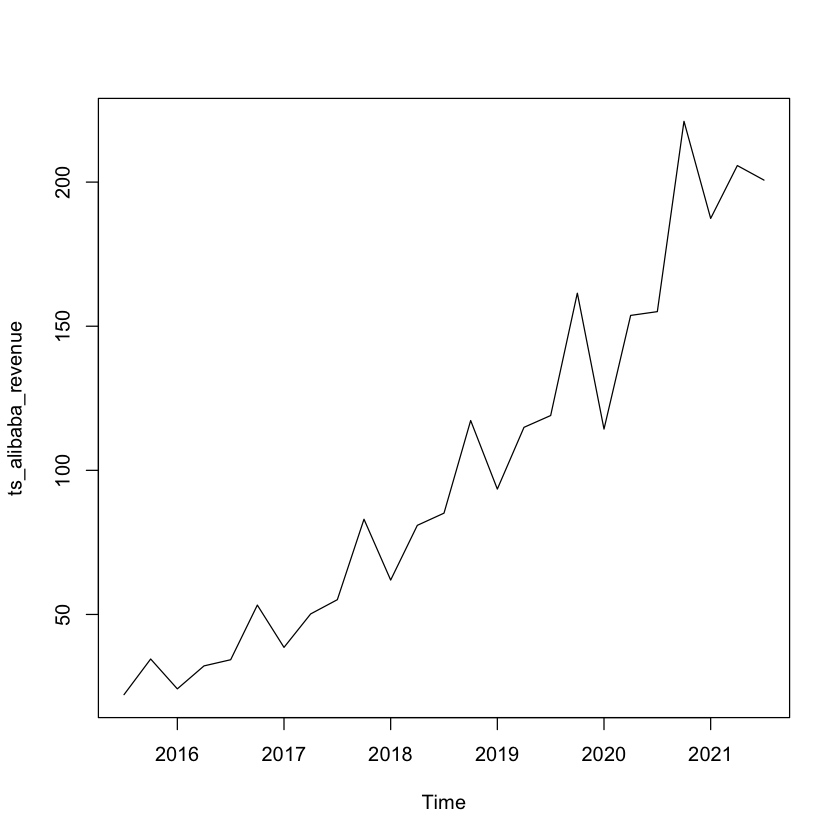

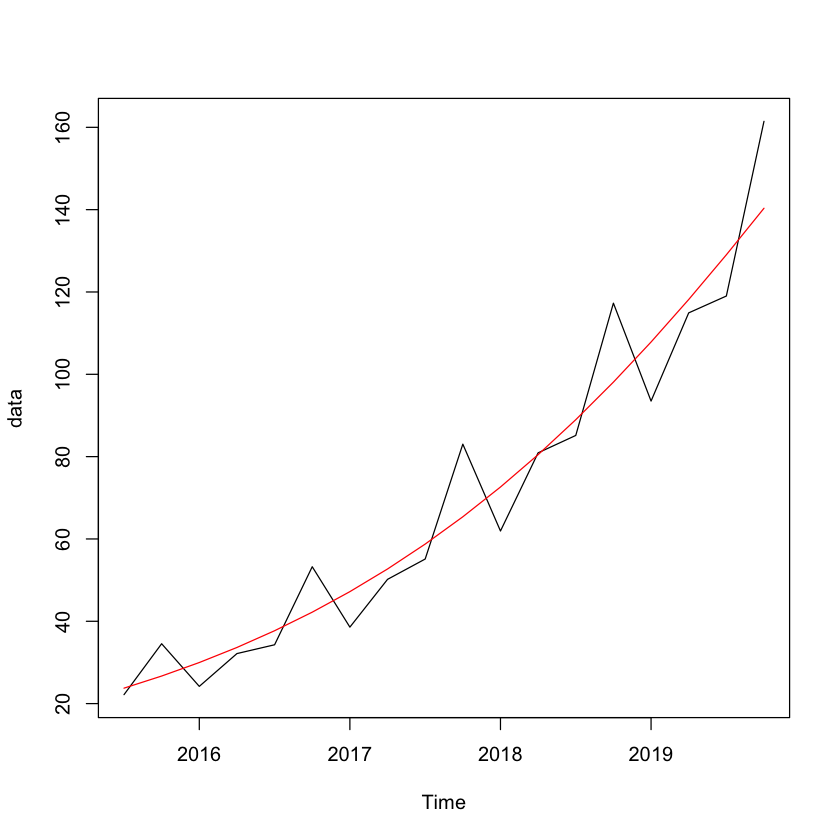

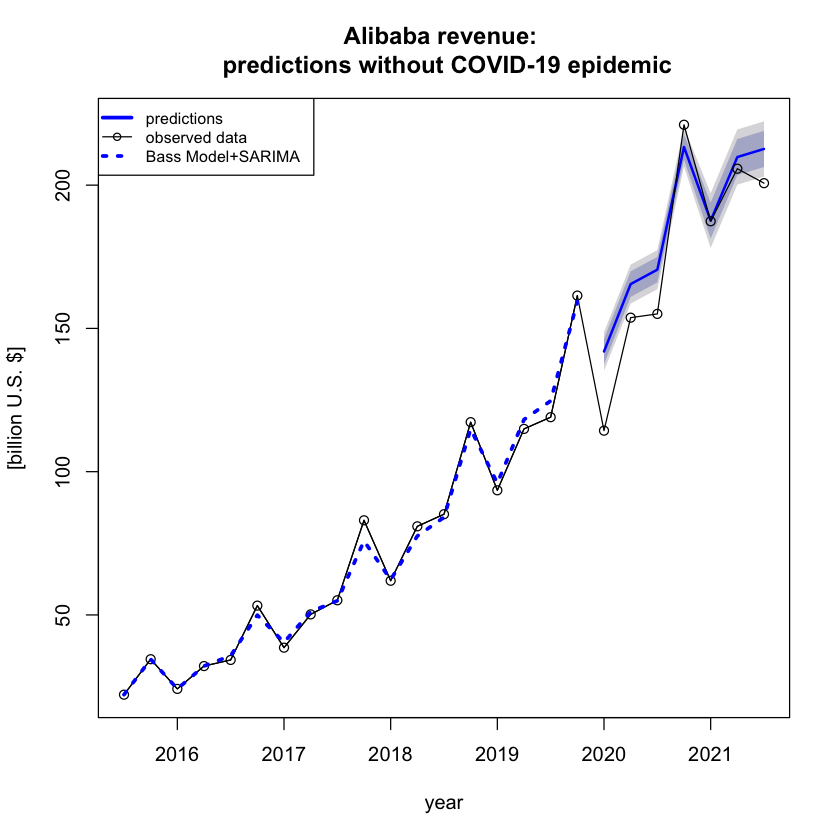

In [147]:
plot(ts_alibaba_revenue)
ts_new <- ts(data=ts_alibaba_revenue[1:18], start=c(2015, 3), end=c(2019, 4), frequency = 4)
BM_alibaba_rev_no_covid <-  BM(ts_new, 2015, 3, 2019, 4, 'alibaba', 'revenue')
fit_BM <- ts(data=fitted(BM_alibaba_rev_no_covid), start=c(2015, 3), end=c(2019, 4), frequency = 4)
ts_res_BM_alibaba_rev <- ts(data =  BM_alibaba_rev_no_covid$residuals, start = c(2015, 3), end = c(2019, 4), frequency = 4)

a <- arimaorder(auto.arima(ts_res_BM_alibaba_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))


SARIMA_BM_alibaba_rev <- SARIMA_GBM(ts_new, 2015, 3, 2019, 4,  BM_alibaba_rev_no_covid, a[1:3], a[4:6]) 



    
    
fit_arima_BM <-fitted(SARIMA_BM_alibaba_rev)


filename = paste('plots/predictions_alibaba_revenue_NO_COVID.png', sep = "")
#png(filename, res=100)   


plot(forecast(SARIMA_BM_alibaba_rev, 
              xreg = predict(BM_alibaba_rev_no_covid, newx = 19:25)), 
     #ylim=c(0, 130),
     xlab='year', 
     ylab='[billion U.S. $]',
     main='Alibaba revenue: \n predictions without COVID-19 epidemic'
    )
lines(ts_alibaba_revenue, type='o', col='black')
lines(fit_arima_BM, col='blue', lty=3, lwd=3)
legend('topleft', legend=c("predictions", "observed data", "Bass Model+SARIMA"),
       col=c('blue', 'black', 'blue'), lwd=c(3,1,3), lty=c(1,1,3),  pch = c(NA, 1, NA), cex=0.8)
#dev.off()

Warning message in nls.lm(par = prelimestimates, fn = ff1, t = t):
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


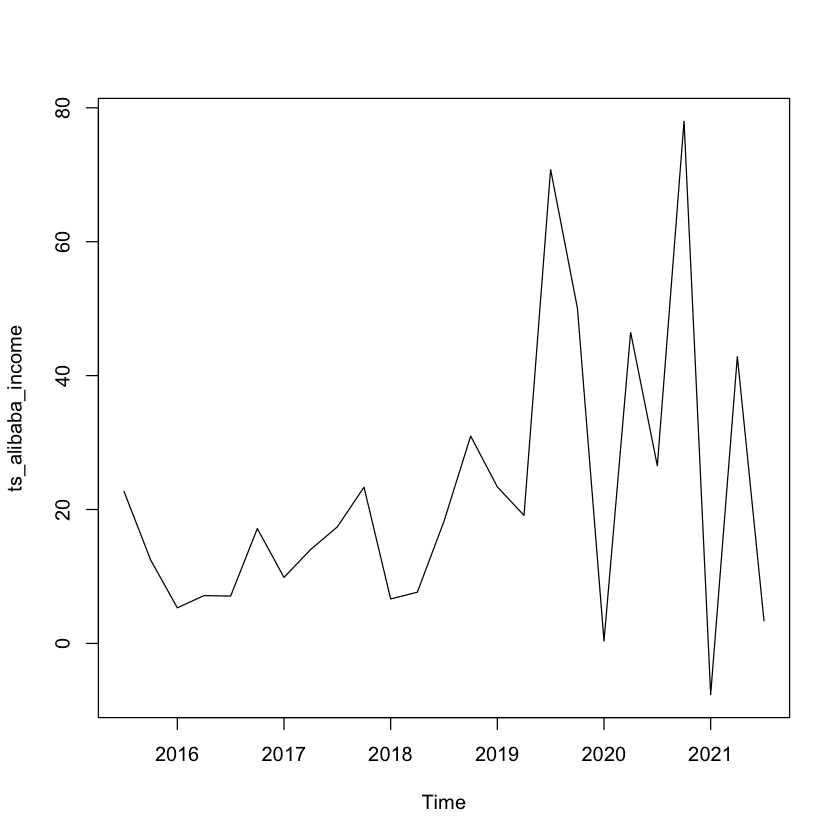

p d q 
0 1 0 


pdf 
  2

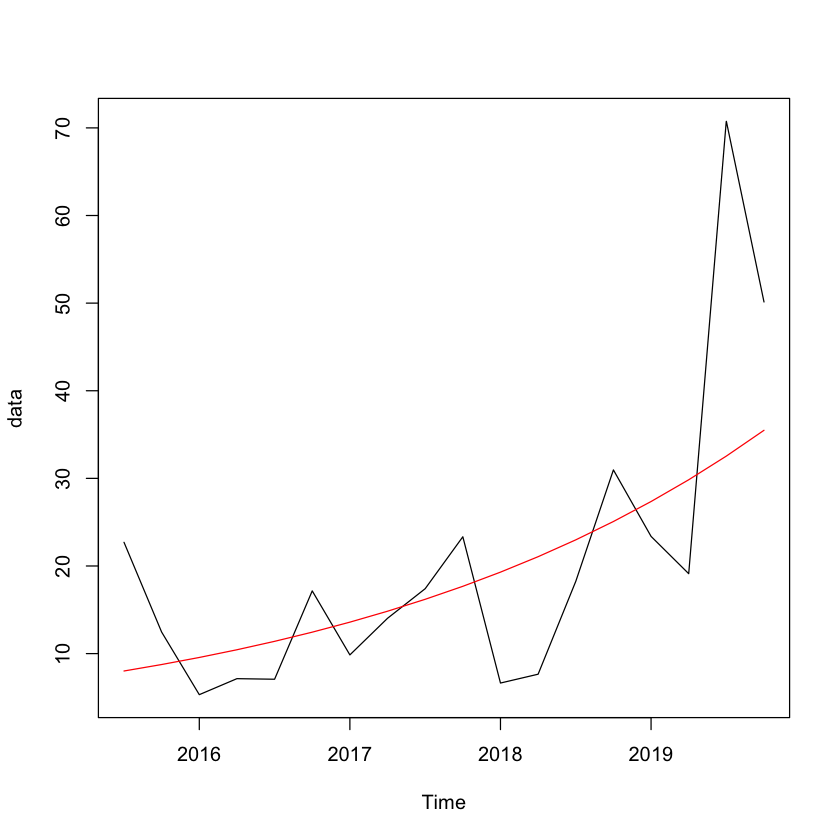

In [153]:
plot(ts_alibaba_income)
ts_new <- ts(data=ts_alibaba_income[1:18], start=c(2015, 3), end=c(2019, 4), frequency = 4)
BM_alibaba_inc_no_covid <-  BM(ts_new, 2015, 3, 2019, 4, 'alibaba', 'income')
fit_BM <- ts(data=fitted(BM_alibaba_inc_no_covid), start=c(2015, 3), end=c(2019, 4), frequency = 4)
ts_res_BM_alibaba_inc <- ts(data =  BM_alibaba_inc_no_covid$residuals, start = c(2015, 3), end = c(2019, 4), frequency = 4)

a <- arimaorder(auto.arima(ts_res_BM_alibaba_inc, seasonal = T, stepwise=FALSE, approximation=FALSE))
print(a)


SARIMA_BM_alibaba_inc <- SARIMA_GBM(ts_new, 2015, 3, 2019, 4,  BM_alibaba_inc_no_covid, a[1:3], c(1,1,0)) 



    
    
fit_arima_BM <-fitted(SARIMA_BM_alibaba_inc)


filename = paste('plots/predictions_alibaba_income_NO_COVID.png', sep = "")
png(filename, res=100)   


plot(forecast(SARIMA_BM_alibaba_inc, 
              xreg = predict(BM_alibaba_inc_no_covid, newx = 19:25)), 
     #ylim=c(0, 130),
     xlab='year', 
     ylab='[billion U.S. $]',
     main='Alibaba income: \n predictions without COVID-19 epidemic'
    )
lines(ts_alibaba_income, type='o', col='black')
lines(fit_arima_BM, col='blue', lty=3, lwd=3)
legend('topleft', legend=c("predictions", "observed data", "Bass Model+SARIMA"),
       col=c('blue', 'black', 'blue'), lwd=c(3,1,3), lty=c(1,1,3),  pch = c(NA, 1, NA), cex=0.8)
dev.off()

pdf 
  2

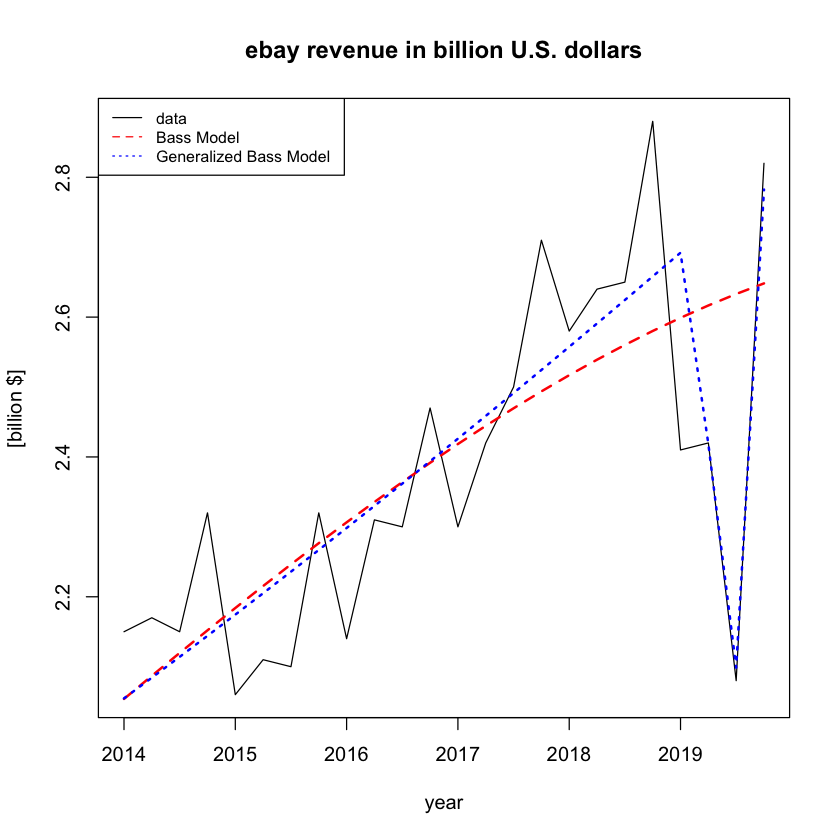

In [55]:
#plot(ts_ebay_revenue)
ts_new <- ts(data=ts_ebay_revenue[1:24], start=c(2014, 1), end=c(2019, 4), frequency = 4)
BM_ebay_rev_no_covid <-  GBM(ts_new, 2014, 1, 2019, 4, 1, c(20, -0.3, -0.4), 'exp', 'ebay', 'revenue' )





fit_BM <- ts(data=fitted(BM_ebay_rev_no_covid), start=c(2014, 1), end=c(2019, 4), frequency = 4)
ts_res_BM_ebay_rev <- ts(data =  BM_ebay_rev_no_covid$residuals, start = c(2014, 1), end = c(2019, 4), frequency = 4)

a <- arimaorder(auto.arima(ts_res_BM_ebay_rev, seasonal = T, stepwise=FALSE, approximation=FALSE))

SARIMA_BM_ebay_rev <- SARIMA_GBM(ts_new, 2014, 1, 2019, 4,  BM_ebay_rev_no_covid, a[1:3], a[4:6]) 
    
    
fit_arima_BM <-fitted(SARIMA_BM_ebay_rev)


filename = paste('plots/predictions_ebay_revenue_NO_COVID.png', sep = "")
png(filename, res=100)   


plot(forecast(SARIMA_BM_ebay_rev, 
              xreg = predict(BM_ebay_rev_no_covid, newx = 25:30)), 
     #ylim=c(0, 130),
     xlab='year', 
     ylab='[billion U.S. $]',
     main='ebay revenue: \n predictions without COVID-19 epidemic'
    )
lines(ts_ebay_revenue, type='o', col='black')
lines(fit_arima_BM, col='blue', lty=3, lwd=3)
legend('topleft', legend=c("predictions", "observed data", "Bass Model+SARIMA"),
       col=c('blue', 'black', 'blue'), lwd=c(3,1,3), lty=c(1,1,3),  pch = c(NA, 1, NA), cex=0.8)
dev.off()







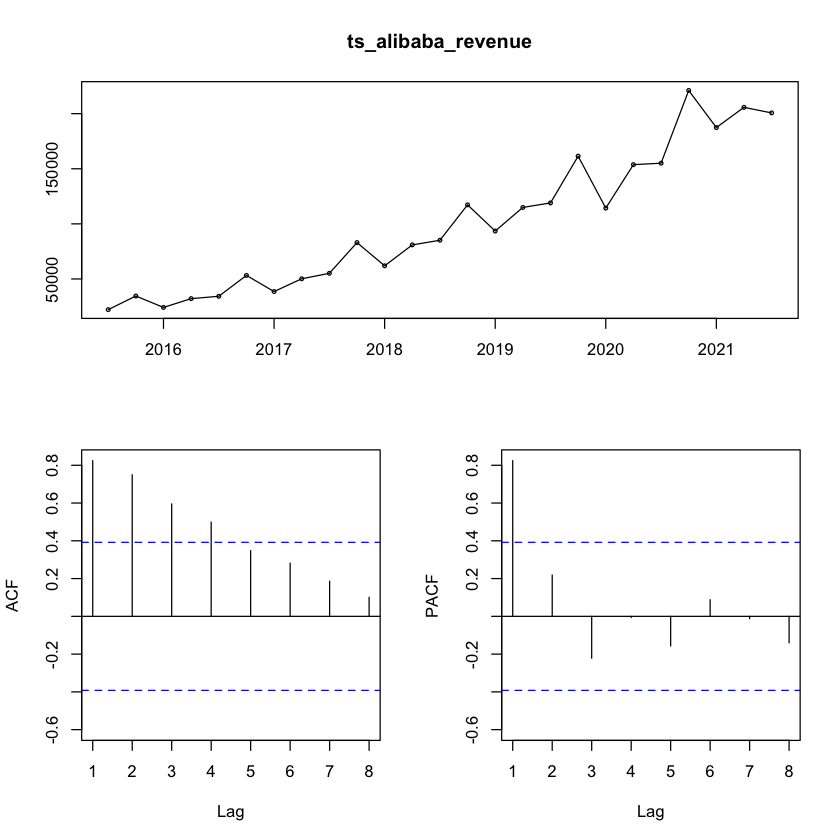

Series: ts_alibaba_revenue 
ARIMA(0,1,0)(0,1,0)[4] 

sigma^2 estimated as 124859971:  log likelihood=-214.81
AIC=431.61   AICc=431.83   BIC=432.61

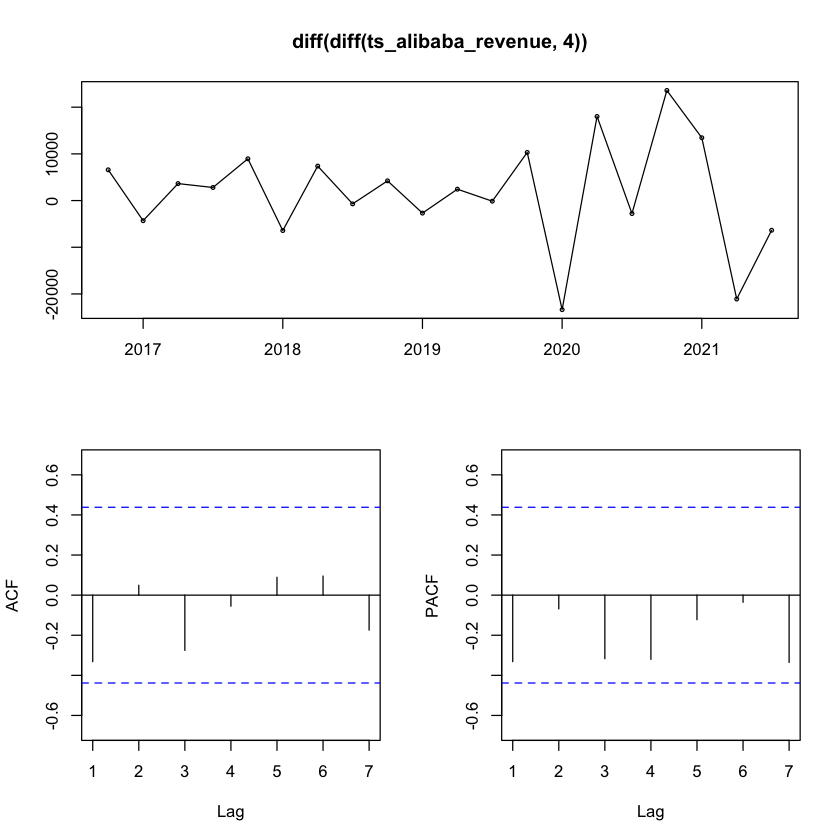

In [298]:
#buon esempio da mostrare dove basta differenziare sia seasonal che non seasonal
tsdisplay(ts_alibaba_revenue)
tsdisplay(diff(diff(ts_alibaba_revenue, 4)))
auto.arima(ts_alibaba_revenue, seasonal = T, stepwise=FALSE,approximation=FALSE)

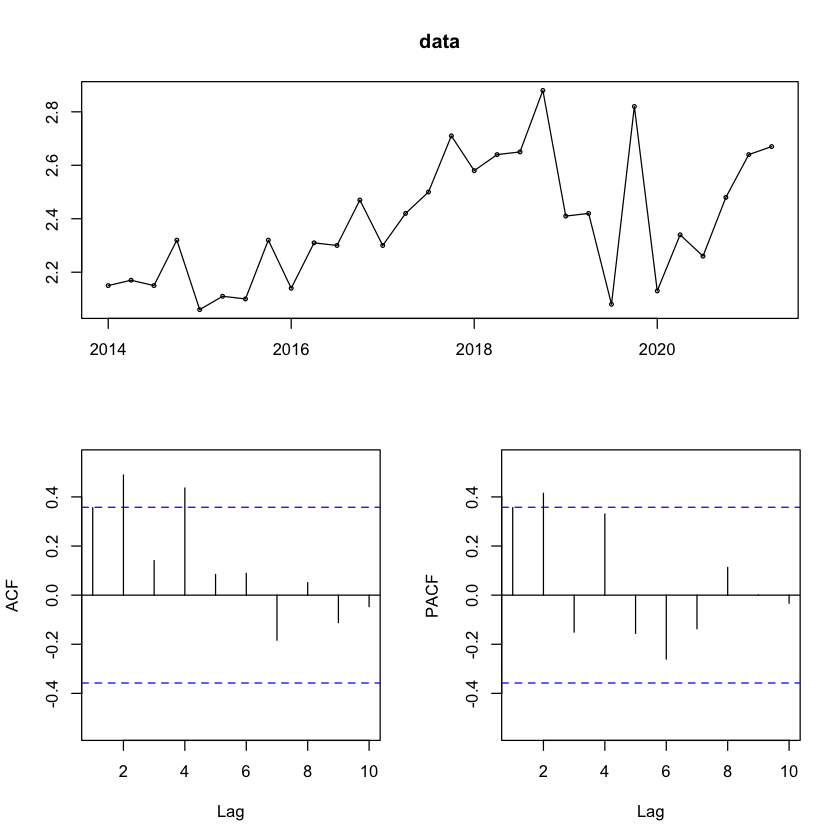

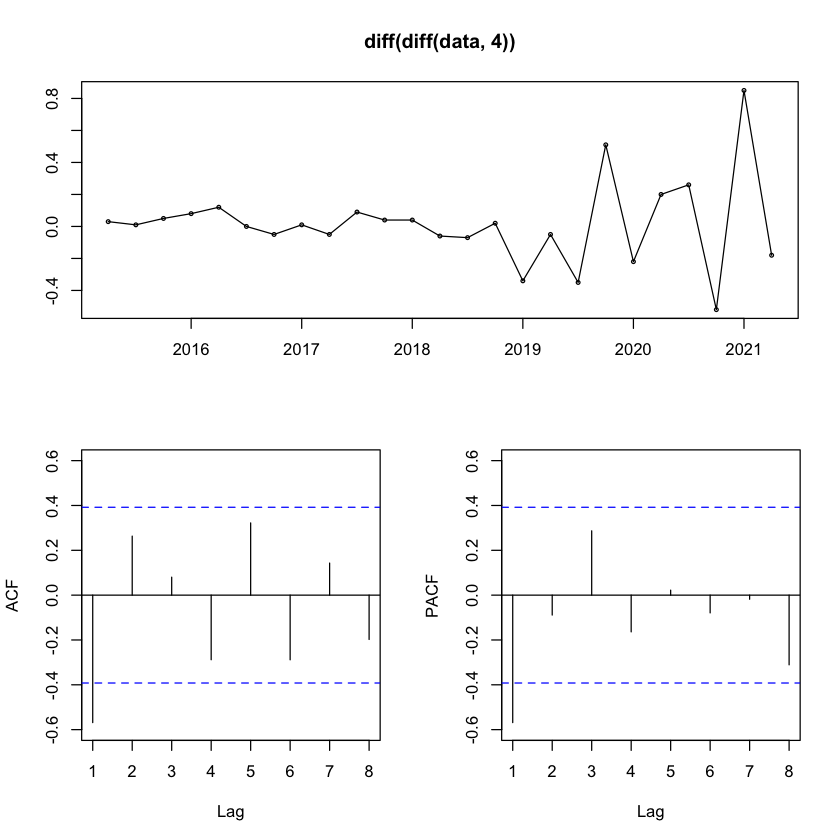

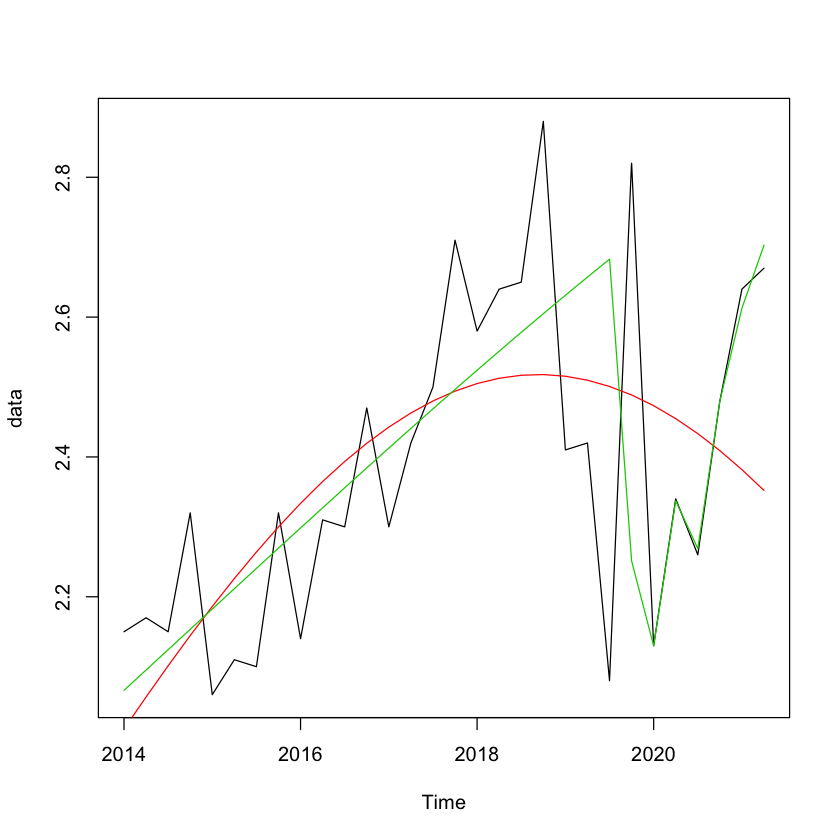

p         d         q         P         D         Q Frequency 
        1         0         0         2         1         0         4

ERROR: Error in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, : non-stationary seasonal AR part from CSS


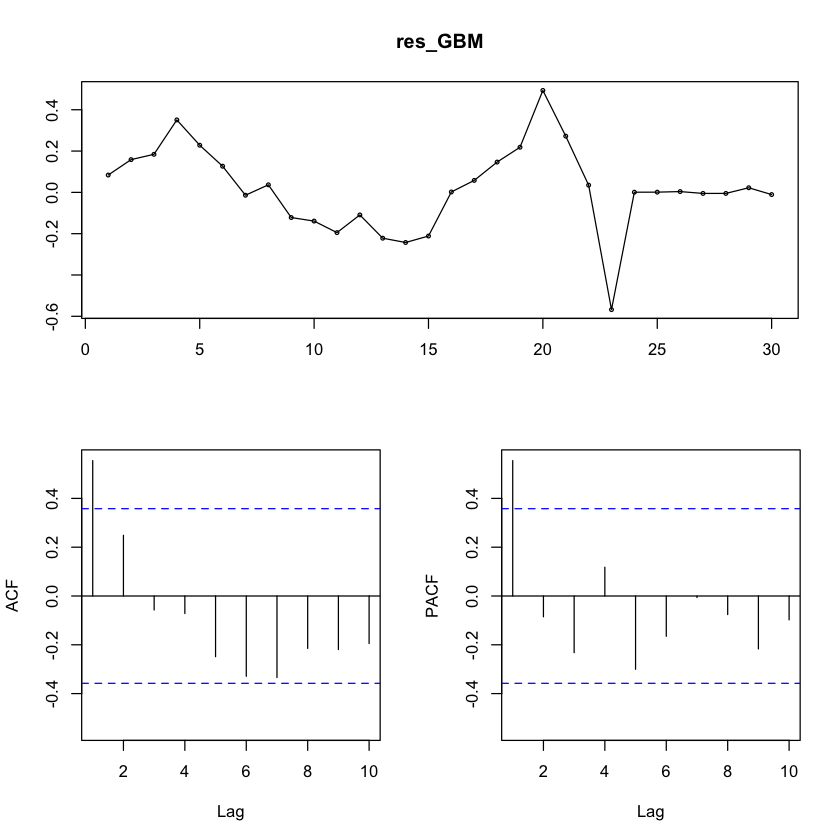

In [361]:
############# BMG EBAY REVENUE

ebay_revenue <- read.csv('Ebay_revenue_new.csv', sep = ';')
GBM_ebay_rev <-  GBM(ts_ebay_revenue, 2014, 1, 2021, 2, 2, c(20, -0.1,-0.1, 24, -0.1,-0.1), 'exp')
ts_res_BMG_ebay_rev <- ts(data =  GBM_ebay_rev$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_ebay_rev, seasonal = T, stepwise=FALSE, approximation=FALSE, D=1))
a
SARIMA_GBM_ebay_rev <- SARIMA_GBM(ts_ebay_revenue, 2014, 1, 2021, 2,  GBM_ebay_rev, a[1:3], a[4:6]) 





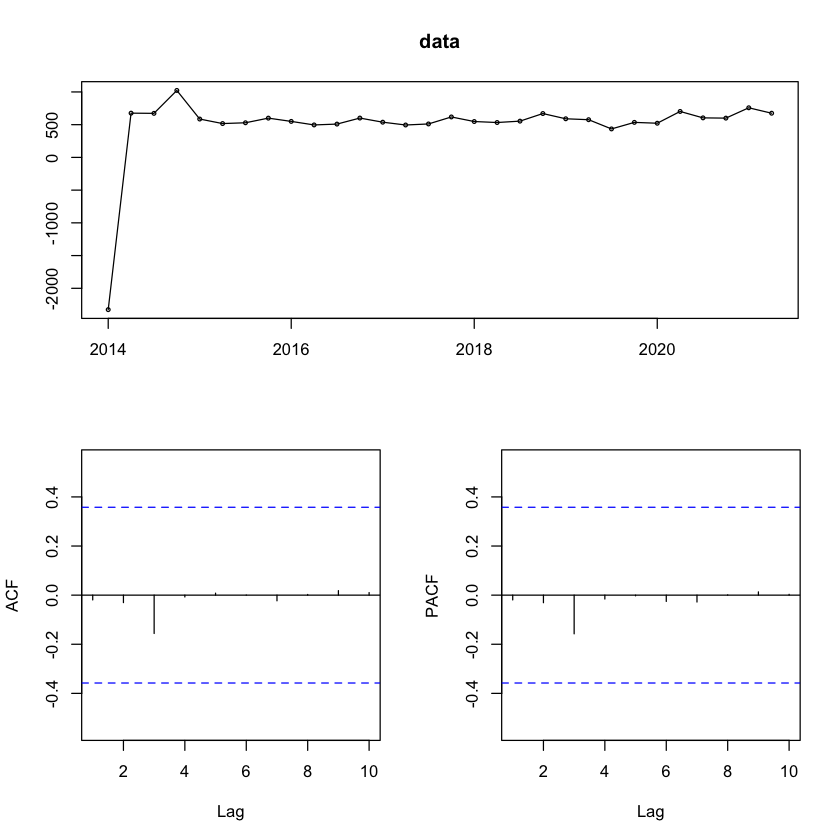

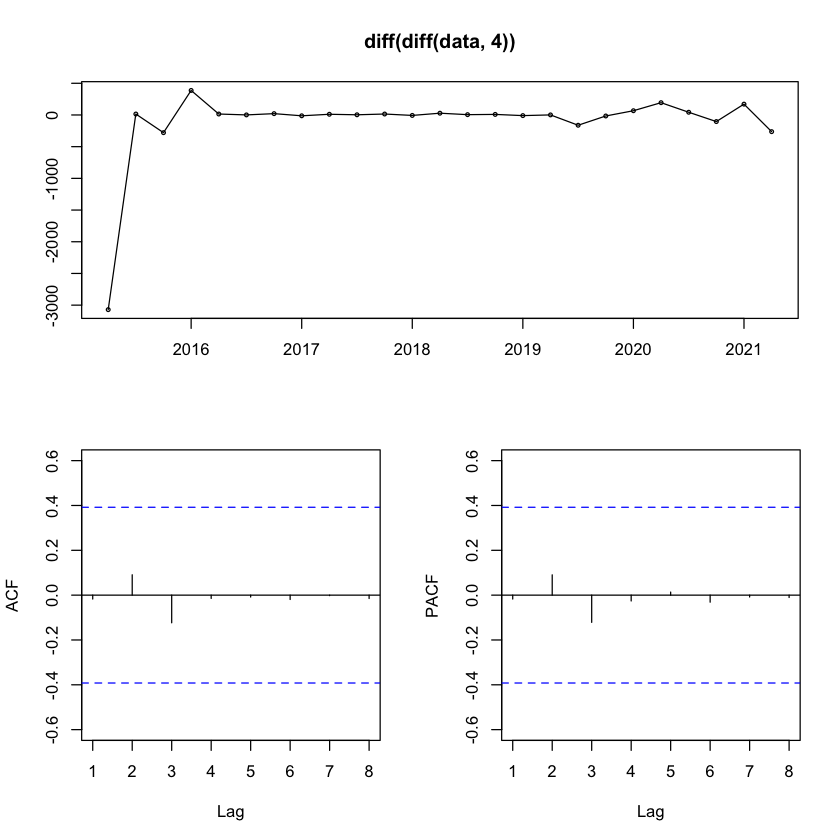

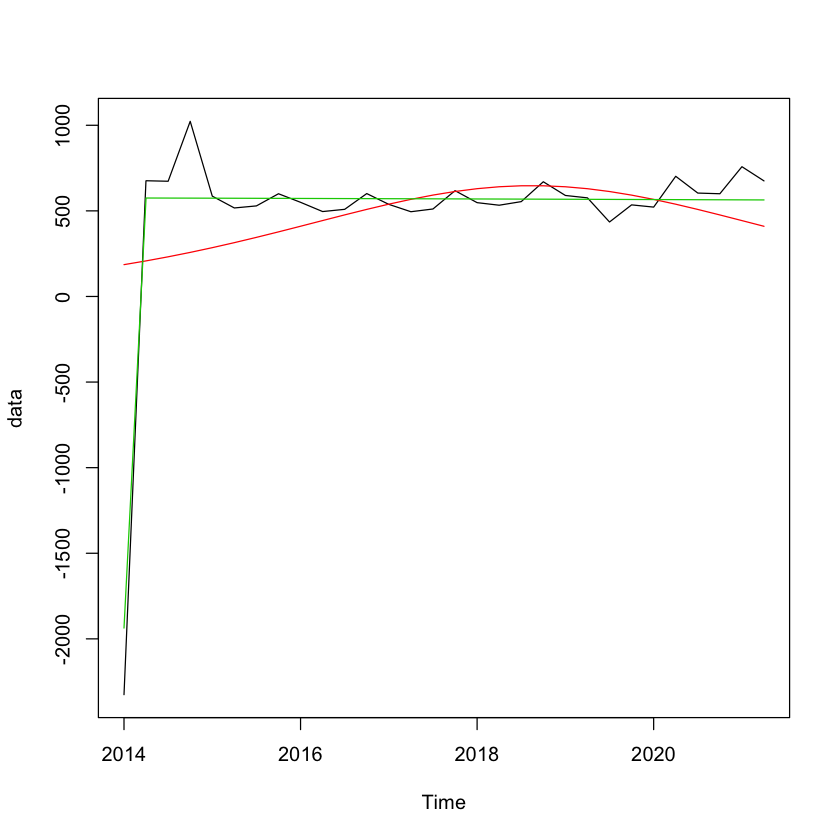

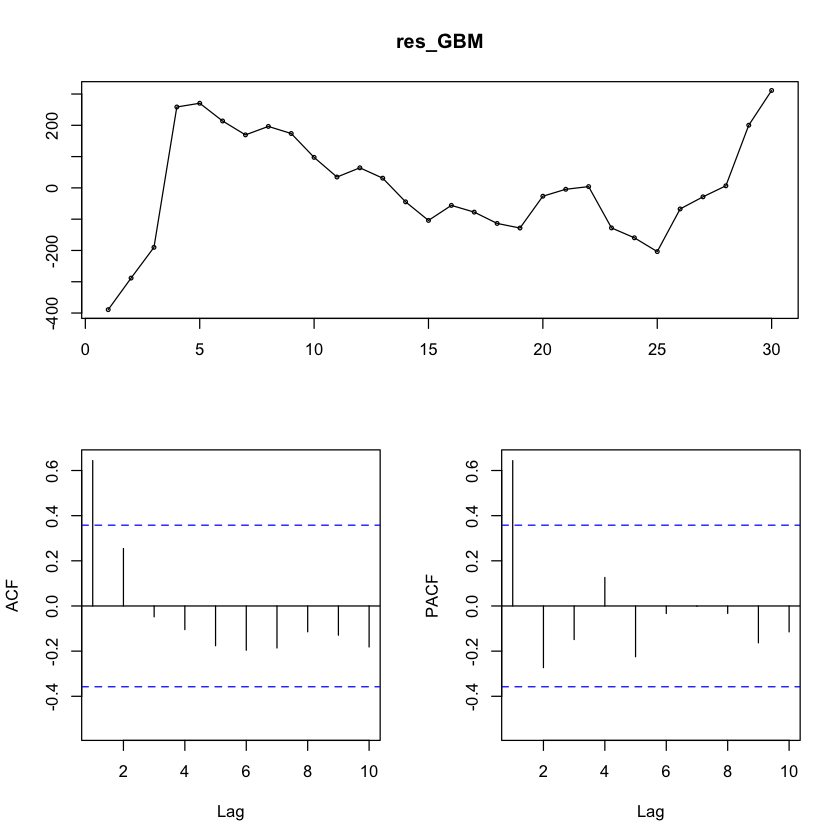

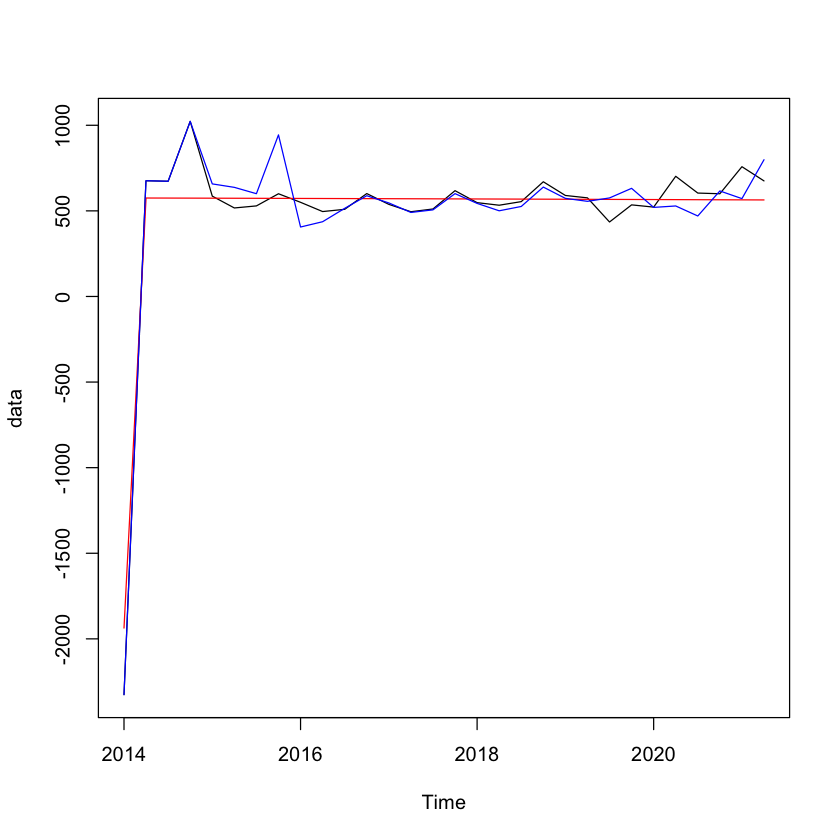

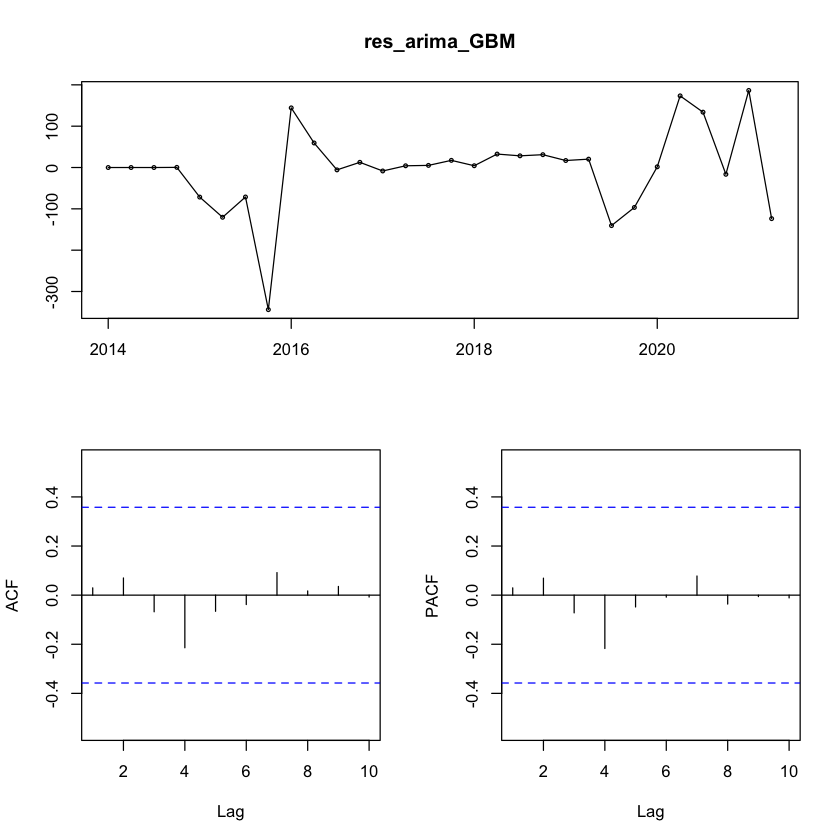

In [376]:
############# BMG EBAY INCOME


GBM_ebay_inc <-  GBM(ts_ebay_income, 2014, 1, 2021, 2, 1, c(1, -0.3, -6), 'exp')
ts_res_BMG_ebay_inc <- ts(data =  GBM_ebay_inc$residuals, start = c(2014, 1), end = c(2021,2), frequency = 4)
a <- arimaorder(auto.arima(ts_res_BMG_ebay_inc, seasonal = T, stepwise=FALSE, approximation=FALSE, D=1))
SARIMA_GBM_ebay_inc <- SARIMA_GBM(ts_ebay_income, 2014, 1, 2021, 2,  GBM_ebay_inc, a[1:3], a[4:6]) 

